### Predgovor
Ova vježba sastoji se od teoretskog i praktičnog dijela. Bez adekvatnog teorijskog razumijevanja, izvedba vježbe biti će značajno izazovnija.

Predlažemo da napravite kopiju ove bilježnice na svoj Colab profil i tamo riješite vježbu. Ne zaboravite uključiti GPU akceleraciju (Runtime->Change runtime type->GPU->Save). \

U slučaju nejasnoća javite se na anja.delic@fer.hr.

# 4. Laboratorijska vježba - generativno modeliranje

Jedan od glavnih katalizatora u razvoju modernog računalnog vida jest dostupnost velikih skupova podataka. Iako su skupovi podataka lako dostupni, proces koji generira podatke je često nepoznat. Cilj ove laboratorijske vježbe jest pokušati aproksimirati proces koji generira dani skup podataka.


## Teorijska podloga generativnom modeliranju

Krenuti ćemo od bolje definicije zadatka.
Pretpostavimo postojanje skupa podataka $D=\{\mathbf{x}_i\}_{i=1}^N$ koji je nastao uzorkovanjem nepoznate distribucije $P_D(\underline{\mathbf{x}})$. Nadalje, pretpostavimo da je svaki primjer $\mathbf{x}_i$ dobiven nezavisnim uzorkovanjem. Naš cilj je aproksimirati nepoznatu distribuciju podataka $P_D(\underline{\mathbf{x}})$ poznatim modelom $P_\theta(\underline{\mathbf{x}})$.
S obzirom da su naši podaci često u kontinuirani ($\underline{\mathbf{x}}$ je kontinuirana slučajna varijabla) baviti ćemo se modeliranjem gustoća vjerojatnosti $p_D(\underline{\mathbf{x}})$ i $p_\theta(\underline{\mathbf{x}})$.

**Problem 1.:** Kako poravnati nepoznati $p_D(\underline{\mathbf{x}})$ i poznati $p_\theta(\underline{\mathbf{x}})$?



U teoriji vjerojatnosti, različitost između dvije distribucije $P(\underline{x})$ i $Q(\underline{x})$ se mjeri pomoću f-divergencije. Jedna od najčešćih mjera iz obitelji f-divergencija je KL-divergencija. KL-divergenciju za kontinuirane slučajne varijable definiramo kao:
$$
\mathrm{KL}(P, Q) = \int_{-\infty}^{+\infty} p(x) \ln\frac{p(x)}{q(x)} dx.
$$
$p$ i $q$ su pripadajuće gustoće vjerojatnosti.

KL-divergencije između distribucije podataka i distribucije modela je primamljiv gubitak za naš optimizacijski postupak. Može se pokazati da je minimizacija KL divergencije između distribucije podataka i distribucije modela ekvivalentna minimizaciji negativne log-izglednosti skupa podataka za učenje:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) \simeq \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \in D} \;\;  [\ln p_\theta(\mathbf{x})]
$$

**Zadatak 1.**: Dokažite navedenu tvrdnju.

Dokaz:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) =
\underset{\theta}{\mathrm{min}} \, \int_{-\infty}^{+\infty} p_D(\mathbf{x}) \ln \frac{p_D(\mathbf{x})}{p_\theta(\mathbf{x})} \, d\mathbf{x}
\\= \underset{\theta}{\mathrm{min}} \, \int_{-\infty}^{+\infty} p_D(\mathbf{x}) \left( \ln p_D(\mathbf{x}) - \ln p_\theta(\mathbf{x}) \right) d\mathbf{x}
\\= \underset{\theta}{\mathrm{min}} \, \int_{-\infty}^{+\infty} p_D(\mathbf{x}) \ln p_D(\mathbf{x}) \, d\mathbf{x} - \int_{-\infty}^{+\infty} p_D(\mathbf{x}) \ln p_\theta(\mathbf{x}) \, d\mathbf{x}
\\= -H(p_D) + \underset{\theta}{\mathrm{min}} \, \left( - \mathbb{E}_{\mathbf{x} \sim p_D}[\ln p_\theta(\mathbf{x})] \right)
\\\simeq \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \sim p_D}[\ln p_\theta(\mathbf{x})].
$$

Entropija distribucije podataka $H(p_D)$ ne ovisi o parametrima modela $\theta$ i stoga je konstanta u optimizaciji. To znači da je minimizacija KL-divergencije svedena na minimizaciju negativne log-izglednosti modela na skupu podataka, što je standardni kriterij za učenje parametara modela.


**Problem 2.**: Definicija modela $p_\theta$.

Naš sljedeći korak je definirati model $p_\theta$. Upravo po definiciji  $p_\theta$ razlikujemo različite generativne modele.
Na primjer autoregresivna faktorizacija modela dovodi do autoregresijskih modela, dok modeliranje nenormalizirane distribucije dovodi do energijskih modela. U ovoj vježbi se fokusiramo  na vrstu generativnih modela koje nazivamo normalizirajući tokovi. Normalizirajući tok $p_\theta$ definiramo pomoću formule za zamjenu varijabli distribucije.

Pretpostavimo da su $\underline{\mathbf{x}}$ i $\underline{\mathbf{z}}$ dvije kontinuirane slučajne varijable. Pretpostavimo da bijekcija $f$ mapira realizacije slučajne varijable $\underline{\mathbf{x}}$ u realizacije od $\underline{\mathbf{z}}$, to jest $\mathbf{z} = f(\mathbf{x})$. S obzirom da je $f$ bijekcija vrijedi i obrat $\mathbf{x} = f^{-1}(\mathbf{z})$. Formulu za zamjenu varijabi distribucije definiramo kao:
$$
 p(\mathbf{x}) = q(\mathbf{z}) \left| \mathrm{det} \frac{\partial \mathbf{z}}{ \partial \mathbf{x}} \right|, \quad \mathbf{z} = f(\mathbf{x})
$$
$\frac{∂ \mathbf{z}}{ ∂ \mathbf{x}}$ predstavlja Jakobijan funkcije $f$ za $\textbf{x}$. det predstavlja determinantu. $|\cdot|$ predstavlja apsolutnu vrijednost.
To jest, drugi član umnoška odgovara apsolutnoj vrijednosti determinante Jakobijana transformacije $f$.

Formulu za zamjenu varijabli ćemo iskoristiti za izgradnju okvira koji nam omogućava implementaciju dubokog generativnog modela.
Ideja je jednostavna, distribuciju $q(\mathbf{z})$ možemo predefinirati (npr. kao Gaussovu distribuciju). Tada nam je jedina nepoznanica bijekcija $f$ koju možemo parametrizirati s $\theta$ te naučiti optimizacijskim postupkom.


Prisjetimo se sljedećih teorema:
1. kompozicija bijekcija je bijekcija, tj $f$ možemo raspisati kao $f = f_1 ∘ f_2 ∘ f_3 ∘ \dots \circ f_K$.
2. pravilo ulančavanja: $\frac{∂ z_3}{ ∂ z_1} = \frac{∂ z_3}{ ∂ z_2}\frac{∂ z_2}{ ∂ z_1} $
3. determinanta umnoška dviju kvadratnih matrica istog reda jednaka je umnošku determinanti svake matrice (Binet-Cauchyjev teorem)
4. Apsolutna vrijednost umnoška dva realna broja je jednaka umnošku apsolutnih vrijednosti: $|a\cdot b| = |a|\cdot |b|$

Bijekciju $f$ možemo promatrati kao kompoziciju funkcija, gdje svaka funkcija $f_i$ prima varijablu $z_{i-1}$ i računa varijablu $z_i$.
Ako uzmemo u obzir prethodno spomenute teoreme, dolazimo do sljedeće formulacije:
$$
 p_\theta (\mathbf{x}) = q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$
gdje je $\mathbf{z}_{0} = \mathbf{x}$.
$q(\mathbf{z}_K)$ može biti proizvoljna distribucija pa je definiramo kao $q(\mathbf{z}_K):= \mathcal{N}(\mathbf{z}_K; 0, \mathrm{I})$.

**Zadatak 2.** Krenuvši od općenite formule za zamjenu varijabli izvedite izraz za normalizirajući tok.

Izvod:
$$
p(\mathbf{x}) = q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f(\mathbf{x})}{ \partial \mathbf{x}} \right|
$$
$$
= q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f_K}{\partial \mathbf{z}_{K-1}} \cdot \frac{\partial f_{K-1}}{\partial \mathbf{z}_{K-2}} \cdots \frac{\partial f_2}{\partial \mathbf{z}_1} \cdot \frac{\partial f_1}{\partial \mathbf{z}_0} \right|
$$
$$
= q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f_K}{\partial \mathbf{z}_{K-1}} \right| \cdot \left| \mathrm{det} \frac{\partial f_{K-1}}{\partial \mathbf{z}_{K-2}} \right| \cdots \left| \mathrm{det} \frac{\partial f_2}{\partial \mathbf{z}_1} \right| \cdot \left| \mathrm{det} \frac{\partial f_1}{\partial \mathbf{z}_0} \right|
$$
$$
= q(\mathbf{z}_K) \prod_{k=1}^{K} \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1})
$$


Spomenimo još da nas općenito zanima logaritam gustoće vjerojatnosti pa pišemo:
$$
 \ln p_\theta (\mathbf{x}) = \ln q(\mathbf{z}_K) +\sum_{k=1}^K \ln \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}), \tag{1}
$$

Ostala nam je još jedna nepoznanica, a to je dizajn funkcija $f_k$,  $k=1,...,K$.
Dizajn funkcije f ovisi o podacima koje modeliramo. Razmislite kako biste bijekciju modelirali kao gradivni blok dubokog modela.

## Modeliranje 2D skupa podataka normalizirajućim tokom

**Problem 3.** Modeliranje 2D skupa podatka.

In [18]:
import torch
import random
import numpy as np
import torch.nn as nn
from torch.backends import mps

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

import matplotlib.pyplot as plt

In [19]:
class GaussianMixture2DDataset:
    def __init__(self, num_samples, n_comp=2, loc=torch.zeros(2,2), scale=torch.ones(2,2), pi=(torch.ones(2)/2)):
        samples_per_component = (pi * num_samples).long()
        self.samples = torch.cat([torch.randn(samples_per_component[i],2) * scale[i] + loc[i] for i in range(n_comp)], 0)

    def __getitem__(self, idx):
        return self.samples[idx]

Promotrimo sljedeći skup podataka. Pretpostavimo da nam je dostupan samo skup podataka $D$. Cilj nam je aproksimirati distribuciju podataka $p_D$ pomoću normalizirajućeg toka.

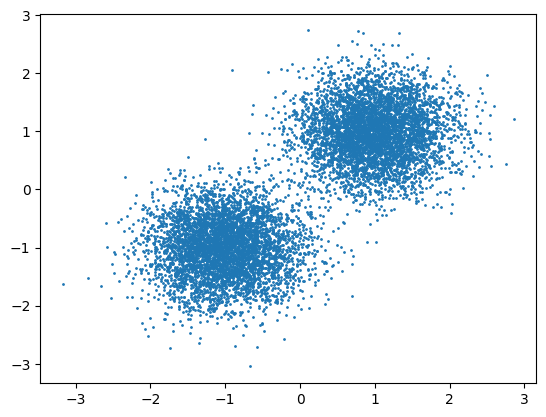

In [20]:
D = GaussianMixture2DDataset(9999, loc=torch.tensor([[-1, -1], [1,1]]), scale=torch.tensor([[0.5, 0.5], [0.5,0.5]])).samples
plt.scatter(D[:, 0], D[:, 1], 1)
plt.show()

S obzirom da modeliramo 2D skup podatka, zanimaju nas funkcije s domenom $\mathbb{R}^2$ i kodomenom $\mathbb{R}^2$ koje imaju inverz.
Definiramo sljedeći implementacijski ovir:

In [21]:
class _Bijection(nn.Module):
    def __init__(self):
        super(_Bijection, self).__init__()

    def forward(self, x):
        pass

    def inverse(self, z):
        pass

Funkcija `forward` implementira unaprijedni prolaz kroz sloj i na izlazu vraća transformirani ulaz i logaritam apsolutne vrijednosti determinante Jakobijana funkcije. \
Funkcija `inverse` implementira inverzni probalz kroz sloj i na izlazu vraća transformirani ulaz.

**Zadatak 3.**: Pokušajmo ponuditi bijektivnu alternativu sloju torch.nn.Linear za dvodimenzionalne podatke. Obratite pozornost na to da je transformaciju potrebno održavati invertibilnom regularizacijskim članom.
Nadopunite forward i inverse funkciju.

Uputa: Linearna transformacija se primjenjuje na svaki primjer u minigrupi nezavisno. Zbog malene dimenzionalnosti, invertiranje i računanje determinante Jakobijana možemo izvesti grubom silom, izravnim pozivom odgovarajućih funkcija torcha.

In [22]:
def sum_except_batch(x, num_dims=1):
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

class BijectiveLinear2D(_Bijection):
    def __init__(self, dim):
        super(_Bijection, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.eye(dim))
        self.bias = nn.Parameter(torch.zeros(1, dim))

    def forward(self, x):   # x has shape NxD
        z = torch.matmul(self.weight, x.T).T + self.bias
        log_abs_det = torch.log(torch.abs(torch.det(self.weight)))
        return z, log_abs_det # shapes NxD, N

    def inverse(self, z):
        weight_inverse = torch.inverse(self.weight)
        x = torch.matmul(z - self.bias, weight_inverse.T)
        return x    # NxD

    def regularization(self):
        return ((self.weight @ self.weight) - torch.eye(self.dim)).abs().sum()




**Zadatak 4.**: Nadopunjavanje izvedbe osnovnog razreda `NormalizingFlow`.

Proučite predloženu nepotpunu izvedbu razreda `NormalizingFlow`. Obratite pozornost na to da konstruktor razreda prima argument `transforms` koji mora biti tipa [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) kako bismo kroz taj objekt mogli iterirati pri unaprijednom i inverznom prolazu. Iteraciju ćemo provoditi `for` petljom i tako prolaziti kroz slojeve normalizirajućeg toka. Predložite potpunu izvedbu razreda `NormalizingFlow` pod pretpostavkom da svi elementi slijednog modela `transforms` nasljeđuju prethodno definirano sučelje `_Bijection`. Vaše rješenje može dodavati nove lokalne metode razredu `NormalizingFlow`.



In [23]:
class NormalizingFlow(nn.Module):
    """
    Base class for normalizing flow.
    """

    def __init__(self, transforms, input_dim):
        super(NormalizingFlow, self).__init__()
        self.transforms = transforms # has to be of type nn.Sequential.

        self.register_buffer('loc', torch.zeros(input_dim))
        self.register_buffer('log_scale', torch.zeros(input_dim))
        # self.loc = self.loc.to(device)
        # self.log_scale = self.log_scale.to(device)
        self.base_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))

    def forward(self, x):
        """Transforms the input sample to the latent representation z.

        Args:
            x (torch.Tensor): input sample

        Returns:
            torch.Tensor: latent representation of the input sample
        """
        z = x
        for transform in self.transforms:
            z, _ = transform(z)
        return z

    def inverse(self, z):
        """Transforms the latent representation z back to the input space.

        Args:
            z (torch.Tensor): latent representation

        Returns:
            torch.Tensor: representation in the input space
        """
        x = z
        for transform in self.transforms[::-1]:
            x = transform.inverse(x)
        return x

    def log_prob(self, x):
        """Calculates the log-likelihood of the given sample x (see equation (1)).

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor: log-likelihood of x
        """
        z = x
        log_abs_det = 0.
        for transform in self.transforms:
            z, log_abs_det_i = transform(z)
            log_abs_det += log_abs_det_i
        log_pz = self.base_dist.log_prob(z).sum(-1)
        log_px =  log_pz + log_abs_det
        return log_px

    def sample(self, num_samples, T=1):
        """Generates new samples from the normalizing flow.

        Args:
            num_samples (int): number of samples to generate
            T (float, optional): sampleing temperature. Defaults to 1.

        Returns:
            torch.Tensor: generated samples
        """
        z_dist = torch.distributions.Normal(torch.zeros_like(self.loc), torch.ones_like(torch.exp(self.log_scale)))
        z = z_dist.sample(torch.Size([num_samples])) * T
        x = self.inverse(z)
        return x

U jednostavnom slučaju, transformaciju normalizirajućeg toka možemo definirati kao slijed linearnih transformacija:

In [24]:
class SimpleNF(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for _ in range(num_steps):
            transforms.append(BijectiveLinear2D(input_dim))

        super(SimpleNF, self).__init__(transforms=transforms, input_dim=input_dim)

    def gather_regularization(self):
        return sum([m.regularization() for m in self.transforms])

Provjerite svoju implementaciju inverza sljedećim kodom:

In [25]:
flow = SimpleNF(2, num_steps=7)
print((flow.inverse(flow(D)) - D).sum().item())
assert (flow.inverse(flow(D)) - D).sum() < 1e-9

0.0


Tok učimo optmizacijom prethodno objašnjenog gubitka.

In [26]:
flow = SimpleNF(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-1)

for iter in range(4000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    loss_reg = flow.gather_regularization()
    total_loss = loss + 0.001 * loss_reg
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()} Reg:{loss_reg.item()}")

Iter 1: Loss:3.0862061977386475 Reg:0.0
Iter 21: Loss:2.5466339588165283 Reg:3.0696539878845215
Iter 41: Loss:2.5891828536987305 Reg:3.063619613647461
Iter 61: Loss:2.5503897666931152 Reg:3.1948657035827637
Iter 81: Loss:2.546922445297241 Reg:3.202280044555664
Iter 101: Loss:2.546659231185913 Reg:3.198953151702881
Iter 121: Loss:2.546635627746582 Reg:3.1950409412384033
Iter 141: Loss:2.546633243560791 Reg:3.1912145614624023
Iter 161: Loss:2.546633243560791 Reg:3.187507152557373
Iter 181: Loss:2.546632766723633 Reg:3.1839118003845215
Iter 201: Loss:2.546633005142212 Reg:3.180424928665161
Iter 221: Loss:2.546633005142212 Reg:3.177043914794922
Iter 241: Loss:2.546632766723633 Reg:3.1737613677978516
Iter 261: Loss:2.546632766723633 Reg:3.170576810836792
Iter 281: Loss:2.546633243560791 Reg:3.1674861907958984
Iter 301: Loss:2.546632766723633 Reg:3.1644890308380127
Iter 321: Loss:2.546633005142212 Reg:3.161579132080078
Iter 341: Loss:2.546632766723633 Reg:3.1587564945220947
Iter 361: Loss:2.

Ako ste do sada sve napravili kako treba, predloženi postav trebao bi uspjeti naučiti tok s gubitkom od oko 2.5.

Provjerimo još jednom stabilnost inverza. Kako biste komentrali rezultate?

In [27]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(1.0865e-05, grad_fn=<SumBackward0>)


Normalizirajućim tokom možemo generirati primjere na sljedeći način:

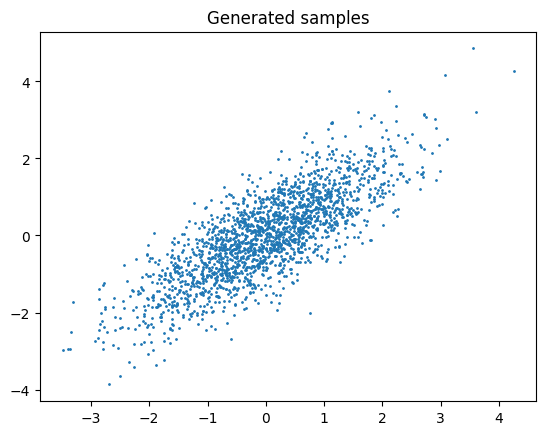

In [28]:
X_ = flow.sample(2000).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.title("Generated samples")
plt.show()

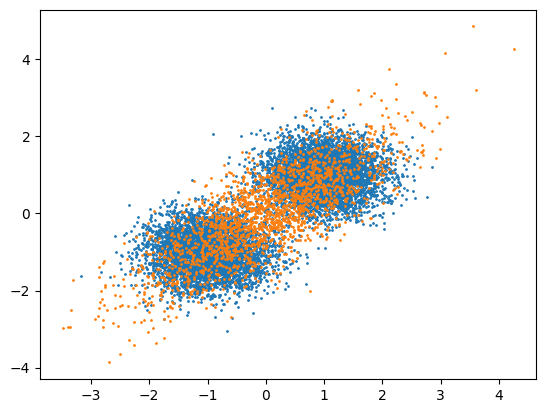

In [29]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

Tok definiran razredom SimpleNF ne može ostvariti veliki kapacitet jer je kompozicija linearnih transformacija i dalje linearna transformacija. Stoga modelirana distribucija ne uspijeva dovoljno dobro aproksimirati $p_D$. Bolju aproksimaciju dobiti ćemo sofisticiranijom arhitekturom pod nazivom [RealNVP](https://arxiv.org/abs/1605.08803). RealNVP se sastoji od "slojeva" afinog miješanja koji su invertibilni po konstrukciji. Imajte na umu da afino miješanje tipično ostvarujemo s više slojeva dubokog modela jer modul miješanja `net` može sadržavati (i tipično sadrži) veći broj uzastopnih nelinearnih transformacija.

Unaprijedni prolaz kroz afino miješanje s ulazom $\mathbf{x}$ dimenzionalnosti $d$ definiramo kao ($m < d$):
$$
\mathbf{z}_{:m} = \mathbf{x}_{:m}
$$
$$
\mathbf{z}_{m:d} = \exp(\ln\mathbf{s}) \odot \mathbf{x}_{m:d} + \mathbf{t}, \quad \ln s, t = net(\mathbf{x}_{:m})
$$

**Zadatak 5.**: Skicirajte računske grafove unaprijednog i unatražnog prolaza kroz afino miješanje. \
Nadopunite predloženi razred `AffineCouplingLayer` s prikladnom funkcionalnošću.
Afino miješanje transformira samo polovicu ulaznog tezora $\mathbf{x}_{m:d}$, dok druga polovica $\mathbf{x}_{:m}$ ostaje nepromijenjena.
Modul miješanja `net` predviđa parametre miješanja `log_s` i `t` iz polovice ulaznog tenzora $\mathbf{x}_{:m}$.

In [31]:
class AffineCouplingLayer(_Bijection):
    def __init__(self, net):
        super(AffineCouplingLayer, self).__init__()
        self.net = net

    def forward(self, x): # NxD
        # ...
        x1, x2 = torch.chunk(x, chunks=2, dim=1)
        log_s, t = self.net(x1)
        log_s = torch.tanh(log_s)
        s = torch.exp(log_s)
        z1 = x1
        z2 = s * x2 + t
        z = torch.cat((z1, z2), dim=1)
        log_det = sum_except_batch(log_s)
        return z, log_det # NxD , N

    def inverse(self, y): # NxD
        # ...
        y1, y2 = torch.chunk(y, chunks=2, dim=1)
        log_s, t = self.net(y1)
        log_s = torch.tanh(log_s)
        s = torch.exp(log_s)
        x1 = y1
        x2 = (y2 - t) / s
        x = torch.cat((x1, x2), dim=1)
        return x # NxD

**Zadatak 6.:** Zamislimo situaciju gdje slijedno primjenjujemo više coupling slojeva. Možemo primijetiti da će se miješati samo jedna polovica tenzora. Kako bismo osigurali da se miješaju obje polovice ulaznog tenzora, uvodimo transformaciju `SwitchSides` koju ćemo primijeniti nakon svakog coupling sloja.
Na taj način osiguravamo da miješanje provodimo naizmjenično na dvjema polovicama ulaznog tenzora. \
Tenzor dijelimo po dimenziji značajki. Dovršite implementaciju razreda `SwitchSides` tako da dijeli ulazni tenzor na dva dijela po dimenziji značajki i zamjenjuje im strane. Možete iskoristiti funkcije [chunk](https://pytorch.org/docs/stable/generated/torch.chunk.html) i [cat](https://pytorch.org/docs/stable/generated/torch.cat.html).

In [32]:
class SwitchSides(_Bijection):

    def forward(self, x):
        # ...
        x1, x2 = torch.chunk(x, chunks=2, dim=1)
        y = torch.cat((x2, x1), dim=1)
        return y, 0.

    def inverse(self, z):
        # ...
        z1, z2 = torch.chunk(z, chunks=2, dim=1)
        x = torch.cat((z2, z1), dim=1)
        return x

**Zadatak 7.:**U nastavku je dan razred `SimpleTransform` kojeg ćemo koristiti kao modul afinog miješanja u coupling sloju. Primijetite da će primjerci tog razreda biti atributi `net` razreda `AffineCouplingLayer`.\
Dovršite implementaciju tako da `model` bude potpuno povezani modul sljedeće arhitekture:

`fc(dim, internal_dim) -> relu -> fc(internal_dim, internal_dim) -> relu -> fc(internal_dim, 2*dim)`.

Dimenziju skrivenog sloja potpuno povezanog modula određujemo parametrom `inflate_coef`. \


Inicijalizirajte parametre modula miješanja tako da modul provodi transformaciju koja je jednaka identitetu. \

In [33]:
class SimpleTransform(nn.Module):
    def __init__(self, dim, inflate_coef=1):
        super(SimpleTransform, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            # ...
            nn.Linear(dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, 2*dim)
        )
        # initialize self.model to identity
        # ...
        with torch.no_grad():
          final = self.model[-1]
          final.weight.zero_()
          final.bias.zero_()


    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t

In [34]:
class SimpleRealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for i in range(num_steps):
            transforms.append(AffineCouplingLayer(SimpleTransform(input_dim//2)))
            if i != num_steps - 1:
                transforms.append(SwitchSides())
        super(SimpleRealNVP, self).__init__(transforms, input_dim)


Tok možemo naučiti na način kako slijedi:

In [35]:
flow = SimpleRealNVP(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-2, nesterov=True, momentum=0.9)

for iter in range(2000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    total_loss = loss
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()}")

Iter 1: Loss:3.0862061977386475
Iter 21: Loss:3.0536389350891113
Iter 41: Loss:3.035438060760498
Iter 61: Loss:2.9598512649536133
Iter 81: Loss:2.6054766178131104
Iter 101: Loss:2.505966901779175
Iter 121: Loss:2.4975955486297607
Iter 141: Loss:2.4950039386749268
Iter 161: Loss:2.492961883544922
Iter 181: Loss:2.491029739379883
Iter 201: Loss:2.4890642166137695
Iter 221: Loss:2.4869439601898193
Iter 241: Loss:2.484571933746338
Iter 261: Loss:2.481905460357666
Iter 281: Loss:2.4789602756500244
Iter 301: Loss:2.4758460521698
Iter 321: Loss:2.4727227687835693
Iter 341: Loss:2.4697346687316895
Iter 361: Loss:2.4669504165649414
Iter 381: Loss:2.4642794132232666
Iter 401: Loss:2.4615399837493896
Iter 421: Loss:2.458585262298584
Iter 441: Loss:2.4554052352905273
Iter 461: Loss:2.4520180225372314
Iter 481: Loss:2.448530435562134
Iter 501: Loss:2.4451041221618652
Iter 521: Loss:2.441896677017212
Iter 541: Loss:2.4389874935150146
Iter 561: Loss:2.4364349842071533
Iter 581: Loss:2.434267044067383

In [36]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(-8.4005e-06, grad_fn=<SumBackward0>)


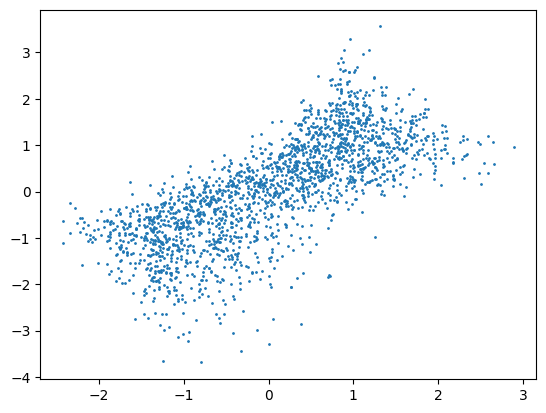

In [37]:
X_ = flow.sample(2000, 1).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

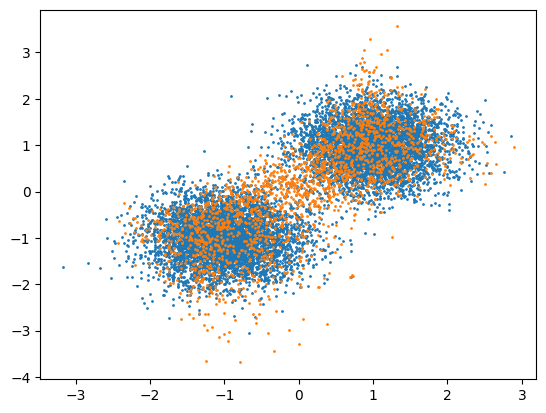

In [38]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)

Kao što vidite, kapacitetniji tok uspijeva dobro aproksimirati dani skup podataka.

## Modeliranje slika normalizirajućim tokom

Naš sljedeći zadatak je modelirati distribuciju slika s normalizirajućim tokom. Slike možemo prestaviti diskretnim tenzorom $\mathbf{x} \in [0, 255]^{C \times H \times W}$. Prisjetimo se da smo normalizirajući tok definirali za kontinuirane slučajne varijable. Stoga, potrebno je transfrormirati skup podataka u kontinuiranu domenu pomoću zašumljivanja:

$$
\mathbf{y} = \mathbf{x} + \mathbf{u}, \quad \mathbf{u} \sim \mathrm{U}[0, 1)
$$
U prestavlja uniformnu razdiobu. Sada, naš model uči modelirati zašumljenu sliku. Više o dekvantizaciji zašumljivanjem možete pronaći [ovdje](https://arxiv.org/pdf/1511.01844.pdf).

MNIST je skup jednostavnih slika pa ćemo se sljedećim pojednostavljenjem. Sliku ćemo ispeglati u vektor i normalizirajućim tokom učiti takvu reprezentaciju slike.

U nastavku je dan kod za pripremanje skupa slika.

In [39]:
from torchvision.datasets import MNIST
import torchvision.transforms as tf
from torch.utils.data import DataLoader, Subset

In [40]:
train_ds = MNIST('.', train=True, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))
test_ds = MNIST('.', train=False, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))

selected_number = 0

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, train_ds[i][1]) for i in range(len(train_ds))]))]
train_ds = Subset(train_ds, indices)

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, test_ds[i][1]) for i in range(len(test_ds))]))]
test_ds = Subset(test_ds, indices)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

In [41]:
def plot_mnist(samples, num_row, num_col):
    assert len(samples) ==  num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(len(samples)):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(samples[i], cmap='gray')
    plt.tight_layout()
    plt.show()

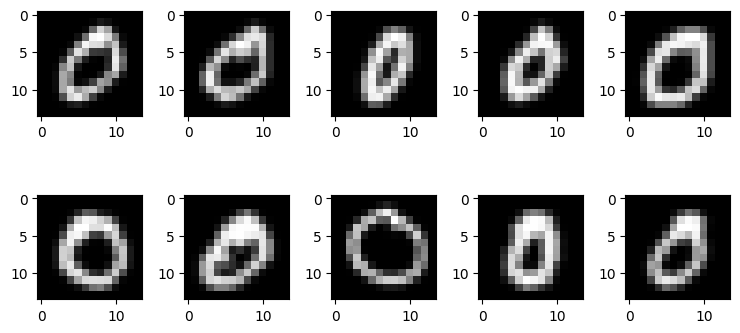

In [42]:
samples = [train_ds[i][0][0] for i in range(10)]
plot_mnist(samples, 2, 5)

**Zadatak 8.:** Predložite arhitekturu toka koji će moći naučiti distribuciju vektoriziranih slika. Predlažemo koristiti rezidualni blok sljedeće arhitekture.

`fc(dim, dim) -> BN -> relu -> fc(dim, dim) -> relu`

Potrebno je dodati rezidualnu vezu od ulaza u rezidualni blok do latentne reprezentacije prije posljednje zglobnice.
Dovršite implementaciju i validirajte utjecaj batchnorma na proces učenja i konačne rezultate.

In [43]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, use_bn=False):
        super(ResidualBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim) if use_bn else nn.Identity(),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
        # ...
        self.f_relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.layers(x)
        out = out + identity
        return self.f_relu(out)

**Zadatak 9.:** Po uzoru na razred `SimpleTransform` dovršite implementaciju razreda `SimpleResidualTransform` čiji se modul miješanja sastoji od rezidualnih blokova. Predlažemo sljedeću arhitekturu:

`fc(dim, internal_dim) -> relu -> res_block(internal_dim, internal_dim) -> fc(internal_dim, 2*dim)`

Eksperimentirajte s brojem rezidualnih blokova. Kako broj rezidualnih blokova utječe na rezultate?

In [44]:
class SimpleResidualTransform(nn.Module):
    def __init__(self, dim, inflate_coef=1):
        super(SimpleResidualTransform, self).__init__()
        # ...
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            nn.Linear(dim, internal_dim),
            nn.ReLU(),
            ResidualBlock(internal_dim, use_bn=True),
            nn.Linear(internal_dim, 2*dim)
        )
        with torch.no_grad():
          final = self.model[-1]
          final.weight.zero_()
          final.bias.zero_()

    def forward(self, x):
        # ...
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t

**Zadatak 10.:** Dovršte implementaciju razreda `RealNVP` po uzoru na `SimpleRealNVP`. `RealNVP` treba koristiti `SimpleResidualTransform` umjesto `SimpleTransform` kao modul miješanja.

In [45]:
class NormalizingFlow(nn.Module):
    """
    Base class for normalizing flow.
    """

    def __init__(self, transforms, input_dim, device='cpu'):
        super(NormalizingFlow, self).__init__()
        self.transforms = transforms # has to be of type nn.Sequential.

        self.register_buffer('loc', torch.zeros(input_dim))
        self.register_buffer('log_scale', torch.zeros(input_dim))

        # self.loc = self.loc.to(device)
        # self.log_scale = self.log_scale.to(device)

        self.base_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))

        self.base_dist.loc = self.loc.to(device)
        self.base_dist.log_scale = self.log_scale.to(device)



    def forward(self, x):
        """Transforms the input sample to the latent representation z.

        Args:
            x (torch.Tensor): input sample

        Returns:
            torch.Tensor: latent representation of the input sample
        """
        z = x
        for transform in self.transforms:
            z, _ = transform(z)
        return z

    def inverse(self, z):
        """Transforms the latent representation z back to the input space.

        Args:
            z (torch.Tensor): latent representation

        Returns:
            torch.Tensor: representation in the input space
        """
        x = z
        for transform in self.transforms[::-1]:
            x = transform.inverse(x)
        return x

    def log_prob(self, x):
        """Calculates the log-likelihood of the given sample x (see equation (1)).

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor: log-likelihood of x
        """
        z = x
        log_abs_det = 0.
        for transform in self.transforms:
            z, log_abs_det_i = transform(z)
            log_abs_det += log_abs_det_i
        log_pz = self.base_dist.log_prob(z).sum(-1)
        log_px =  log_pz + log_abs_det
        return log_px

    def sample(self, num_samples, T=1):
        """Generates new samples from the normalizing flow.

        Args:
            num_samples (int): number of samples to generate
            T (float, optional): sampleing temperature. Defaults to 1.

        Returns:
            torch.Tensor: generated samples
        """
        z_dist = torch.distributions.Normal(torch.zeros_like(self.loc), torch.ones_like(torch.exp(self.log_scale)))
        z = z_dist.sample(torch.Size([num_samples])) * T
        x = self.inverse(z)
        return x

In [46]:
class RealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        # ... define transforms
        for i in range(num_steps):
            transforms.append(AffineCouplingLayer(SimpleResidualTransform(input_dim // 2)))
            if i != num_steps - 1:
                transforms.append(SwitchSides())
        super(RealNVP, self).__init__(transforms, input_dim)

U nastavku je kod za učenje toka.

Obratite pozornost na to da izglednost slike prikazujemo u bitovima po dimenziji (BPD). Podsjetite se što ta mjera predstavlja i kako ju računamo.

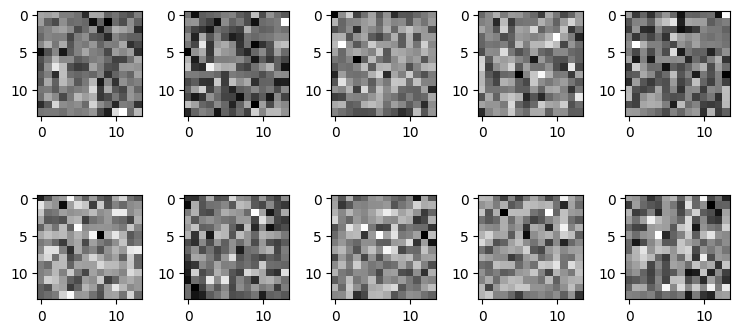

Epoch 1: Train Loss:1266.834867436835 Val BPD: 9.235143661499023


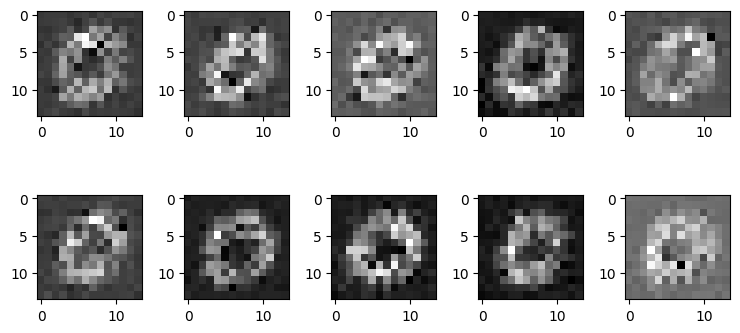

Epoch 11: Train Loss:818.525458153258 Val BPD: 7.94014835357666


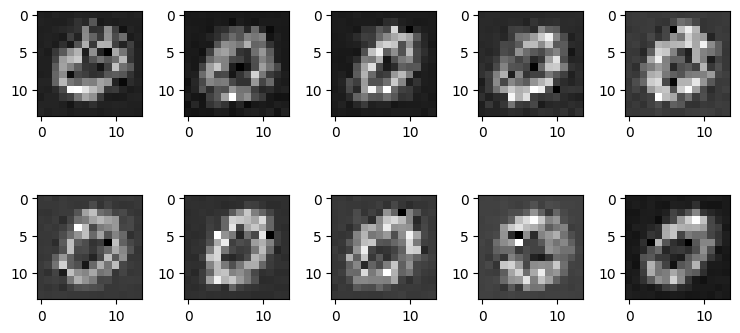

Epoch 21: Train Loss:714.7064819335938 Val BPD: 7.986023902893066


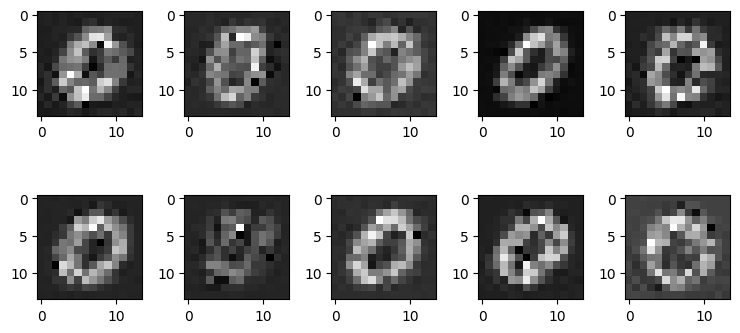

Epoch 31: Train Loss:666.8998555934176 Val BPD: 7.356423854827881


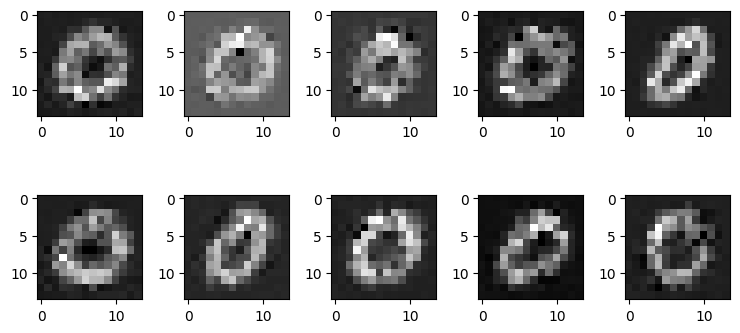

Epoch 41: Train Loss:636.0337316634807 Val BPD: 6.440085411071777


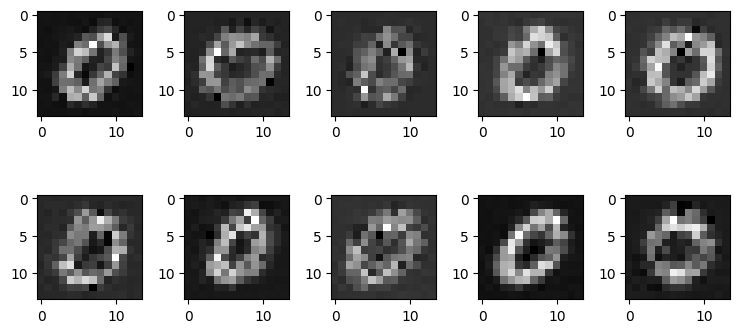

Epoch 51: Train Loss:613.2586436170212 Val BPD: 6.123170852661133


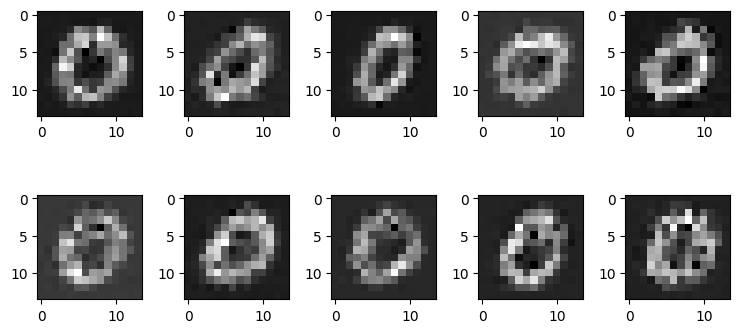

Epoch 61: Train Loss:592.4590025556848 Val BPD: 6.010734558105469


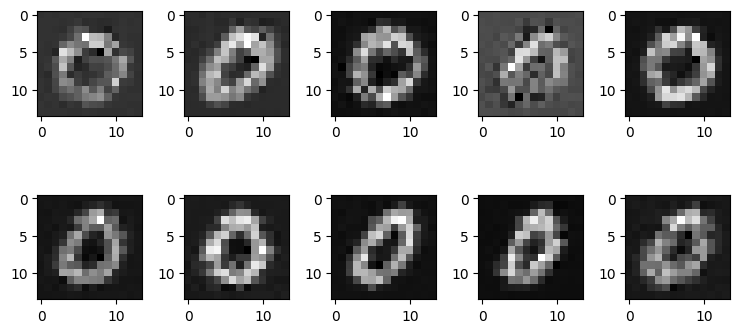

Epoch 71: Train Loss:577.2832213056848 Val BPD: 5.624731540679932


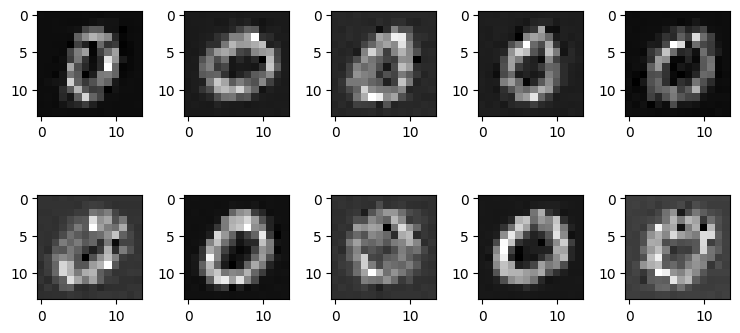

Epoch 81: Train Loss:567.1855936253324 Val BPD: 5.443663120269775


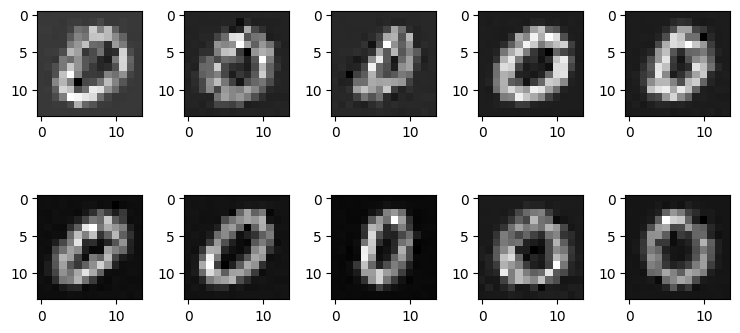

Epoch 91: Train Loss:551.2794592025432 Val BPD: 5.459225654602051


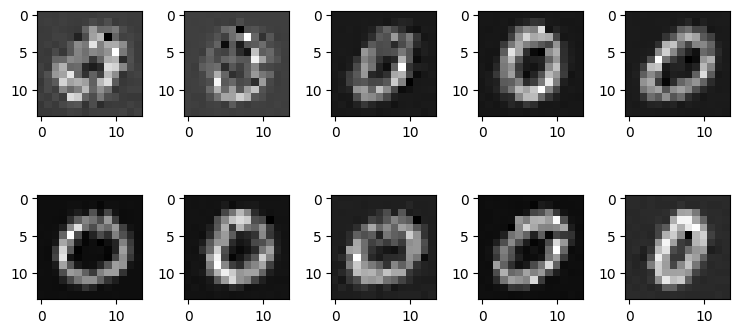

Epoch 101: Train Loss:542.7406356486869 Val BPD: 5.084362506866455


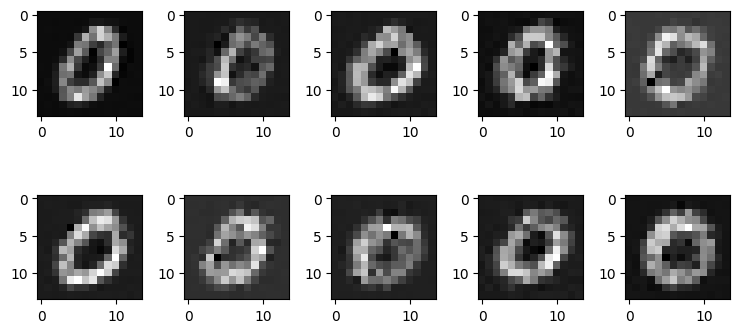

Epoch 111: Train Loss:533.7724752223238 Val BPD: 4.936347484588623


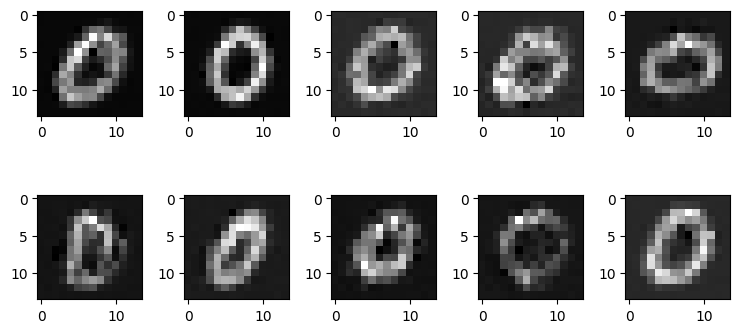

Epoch 121: Train Loss:528.5259477331283 Val BPD: 4.795519828796387


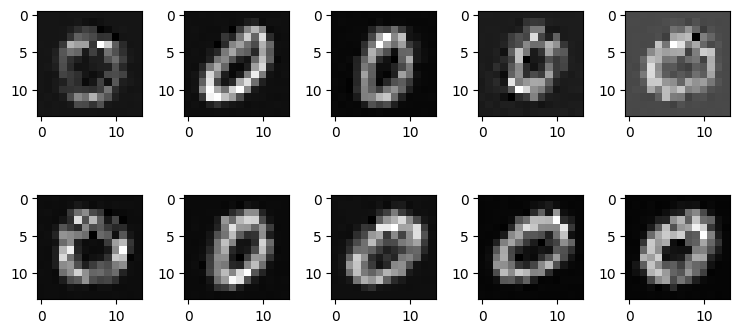

Epoch 131: Train Loss:520.6556480894698 Val BPD: 4.79049015045166


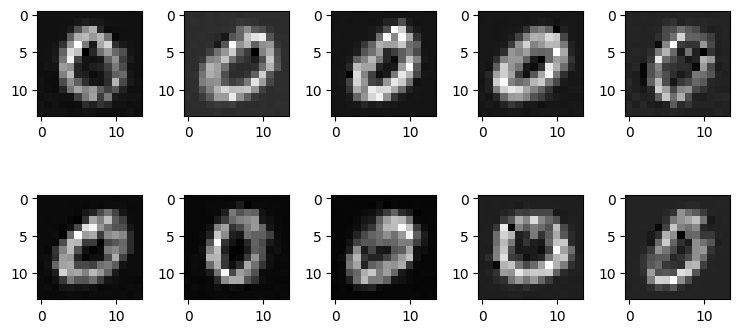

Epoch 141: Train Loss:516.6595848570479 Val BPD: 4.581784248352051


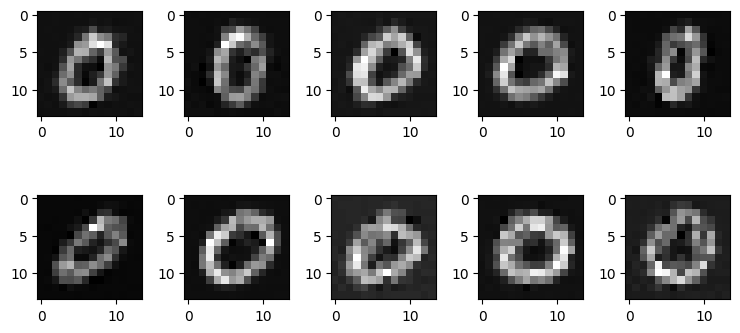

Epoch 151: Train Loss:508.11722710792054 Val BPD: 4.505003929138184


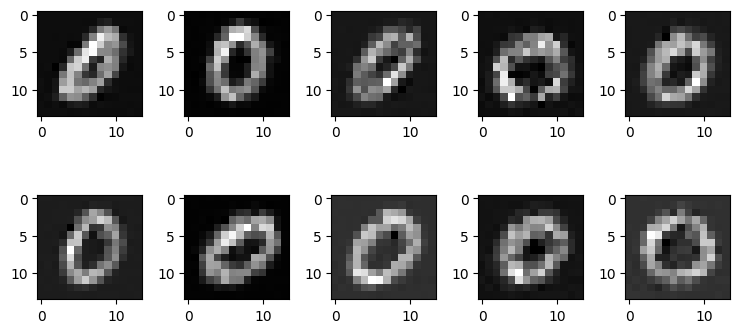

Epoch 161: Train Loss:502.61276374979224 Val BPD: 4.421439170837402


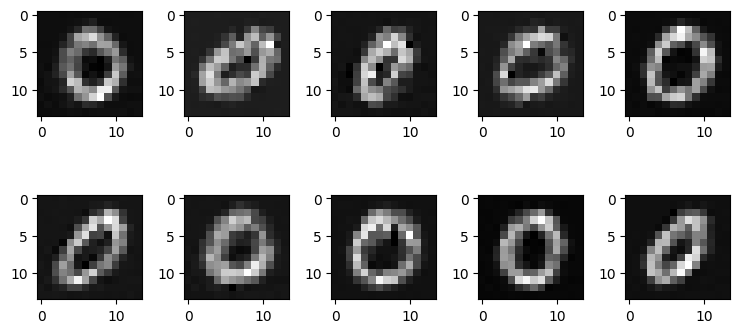

Epoch 171: Train Loss:497.93254706200133 Val BPD: 4.328083038330078


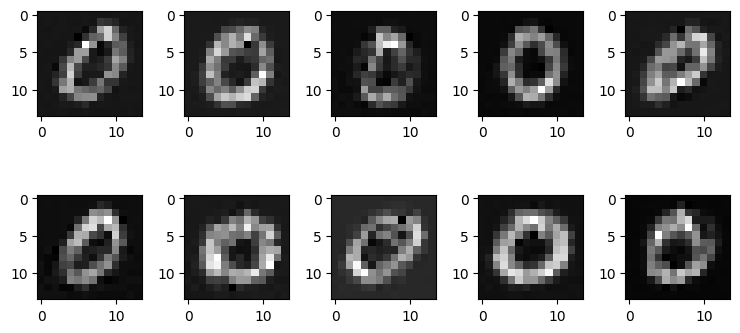

Epoch 181: Train Loss:491.5867731621925 Val BPD: 4.352222442626953


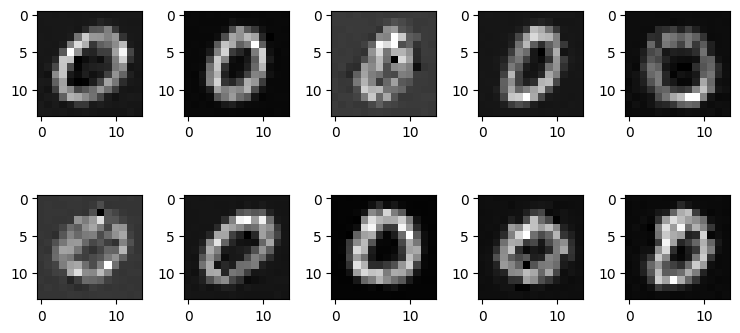

Epoch 191: Train Loss:489.1276569772274 Val BPD: 4.288404941558838


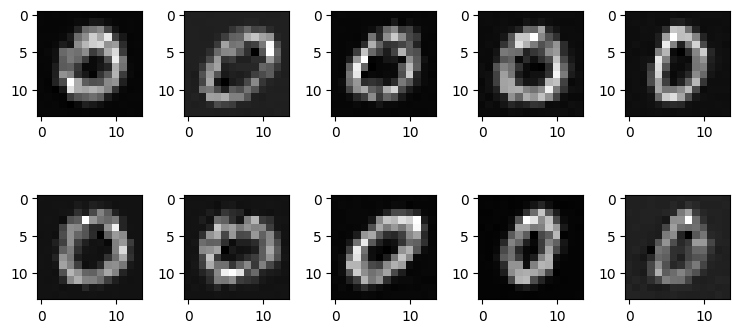

Epoch 201: Train Loss:486.9376415496177 Val BPD: 4.214552402496338


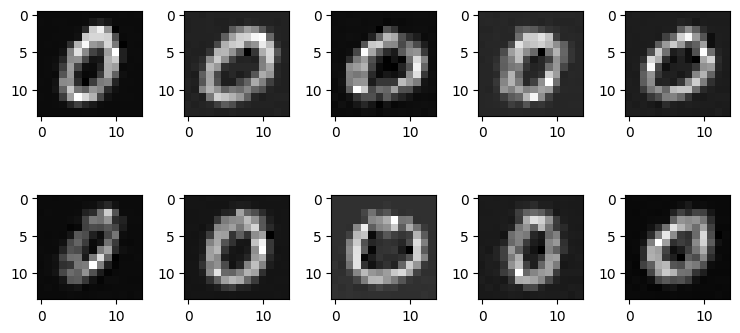

Epoch 211: Train Loss:482.5075242062832 Val BPD: 4.204745769500732


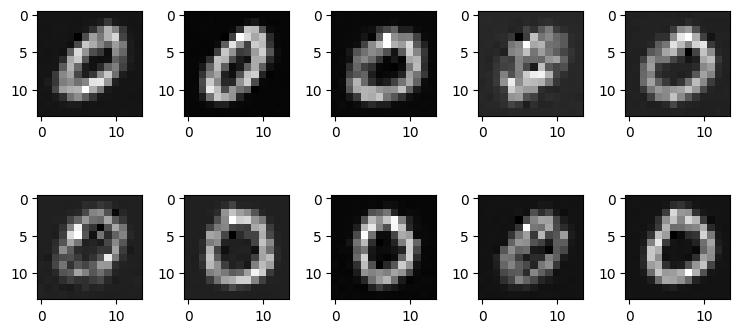

Epoch 221: Train Loss:481.2632628095911 Val BPD: 4.171109199523926


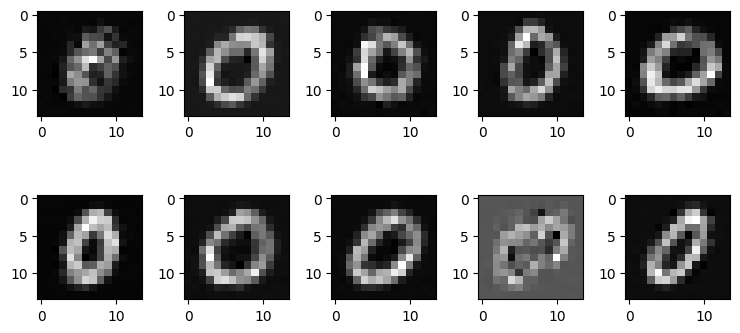

Epoch 231: Train Loss:475.83181502971246 Val BPD: 4.107044696807861


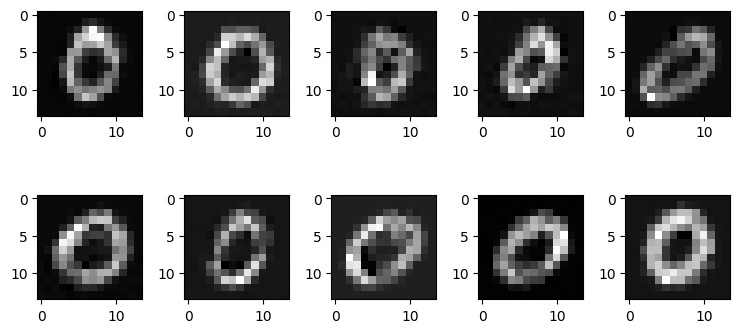

Epoch 241: Train Loss:472.0057535374418 Val BPD: 4.129489421844482


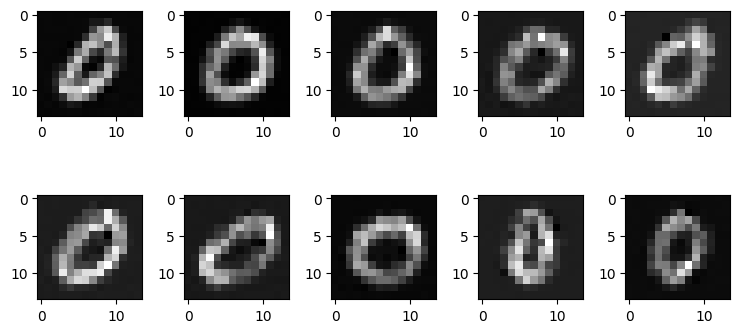

Epoch 251: Train Loss:470.68869148416724 Val BPD: 4.0902862548828125


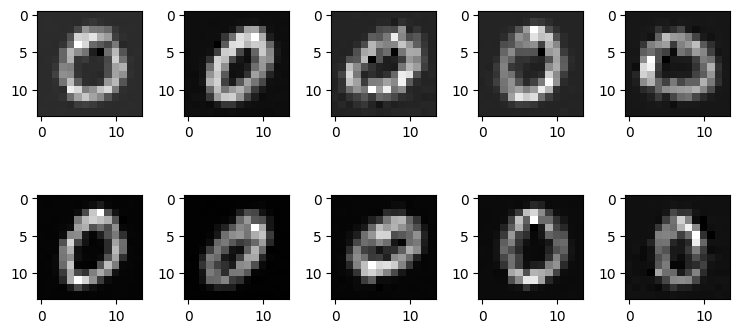

Epoch 261: Train Loss:467.47851497568985 Val BPD: 4.043830394744873


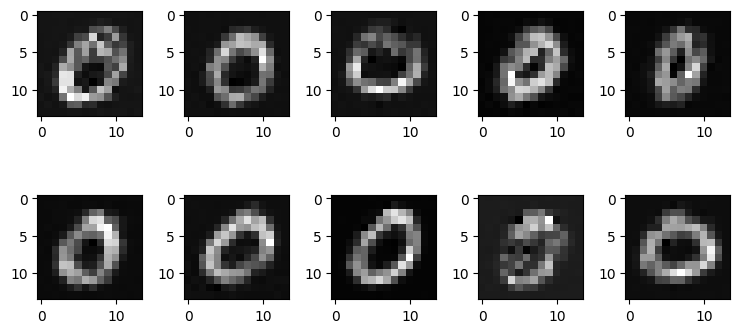

Epoch 271: Train Loss:466.9440125810339 Val BPD: 4.0066423416137695


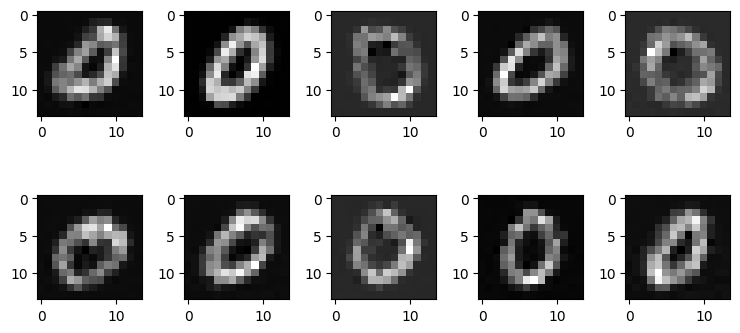

Epoch 281: Train Loss:462.32494338015294 Val BPD: 4.033825874328613


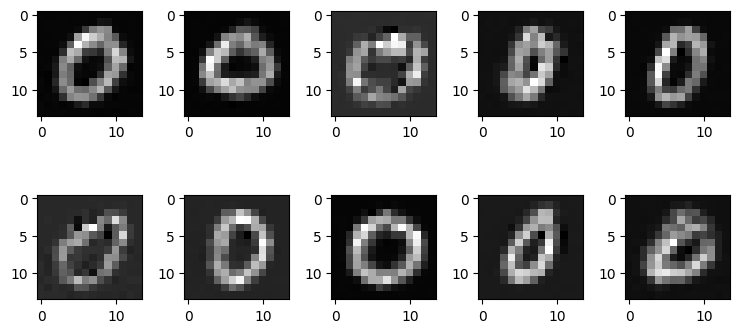

Epoch 291: Train Loss:460.24326535488694 Val BPD: 3.9421448707580566


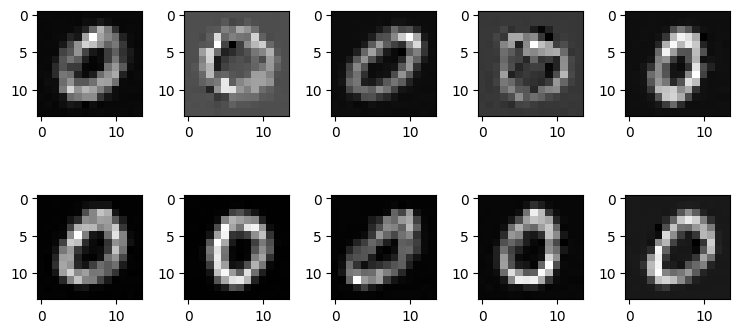

Epoch 301: Train Loss:457.74974806765294 Val BPD: 3.922969341278076


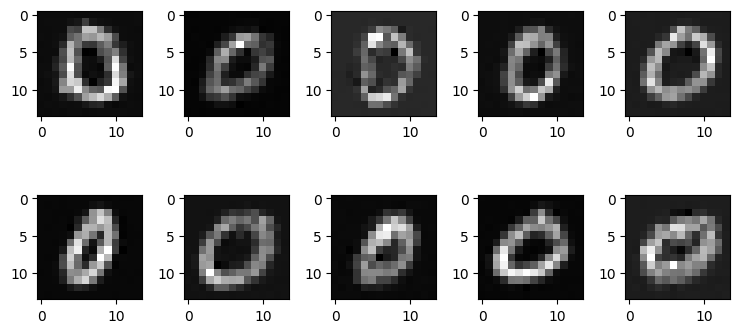

Epoch 311: Train Loss:456.24717225419715 Val BPD: 3.952387571334839


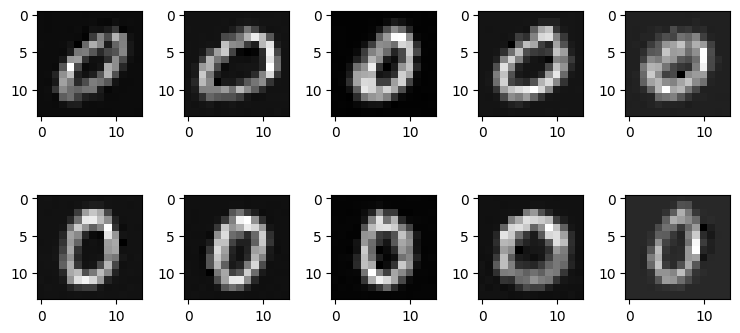

Epoch 321: Train Loss:454.4306731528424 Val BPD: 3.9125046730041504


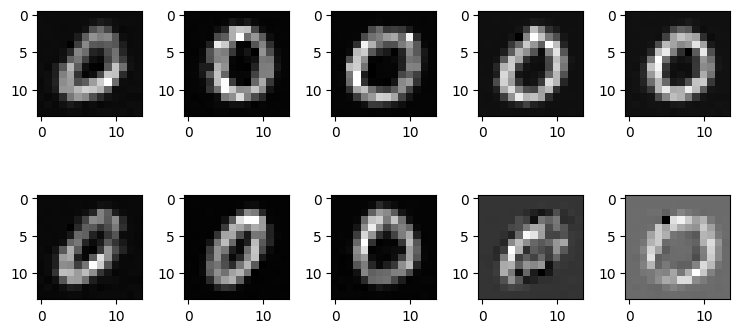

Epoch 331: Train Loss:452.89991078478226 Val BPD: 3.906031847000122


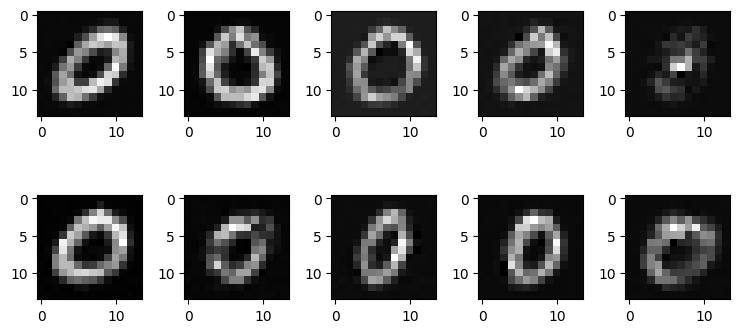

Epoch 341: Train Loss:451.6456675428025 Val BPD: 3.871406078338623


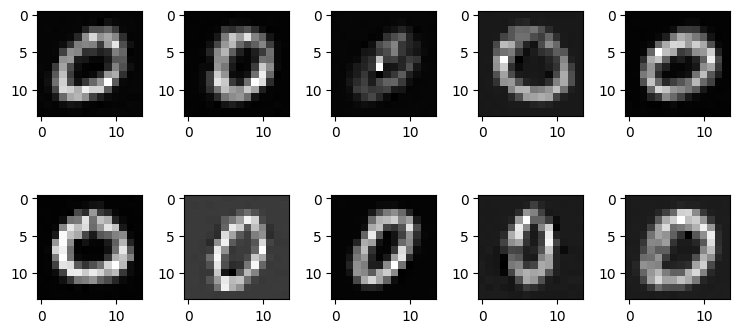

Epoch 351: Train Loss:448.71553981050533 Val BPD: 3.9112770557403564


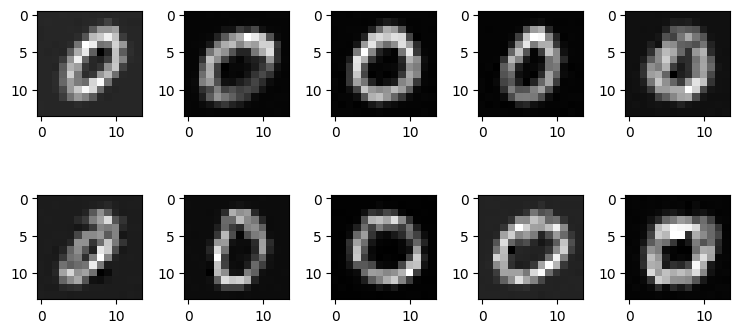

Epoch 361: Train Loss:447.2207206563747 Val BPD: 3.8537888526916504


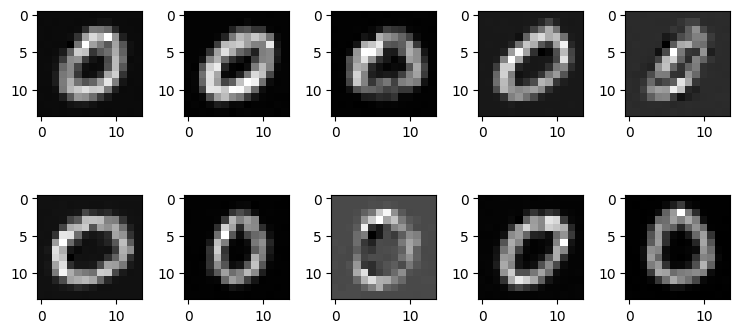

Epoch 371: Train Loss:446.4055266684674 Val BPD: 3.8863039016723633


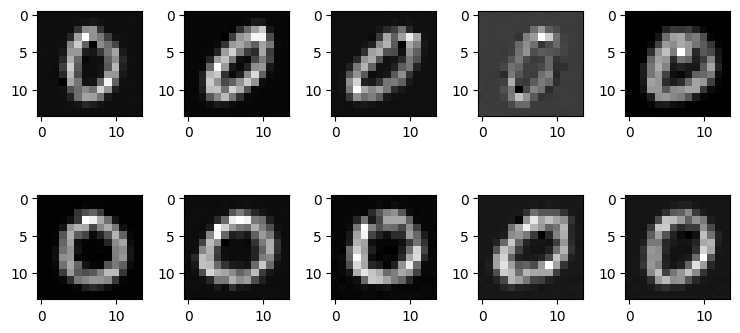

Epoch 381: Train Loss:444.46204262591425 Val BPD: 3.8693411350250244


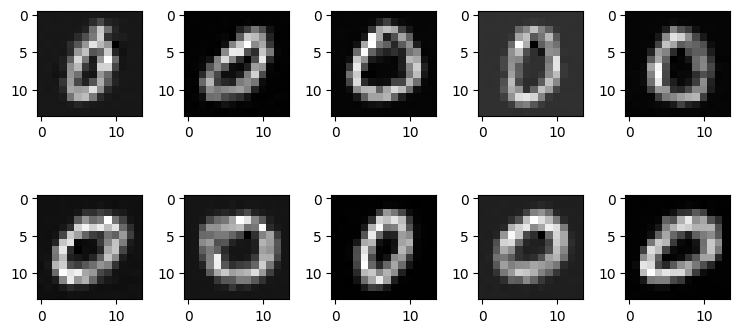

Epoch 391: Train Loss:443.71294451774435 Val BPD: 3.792081356048584


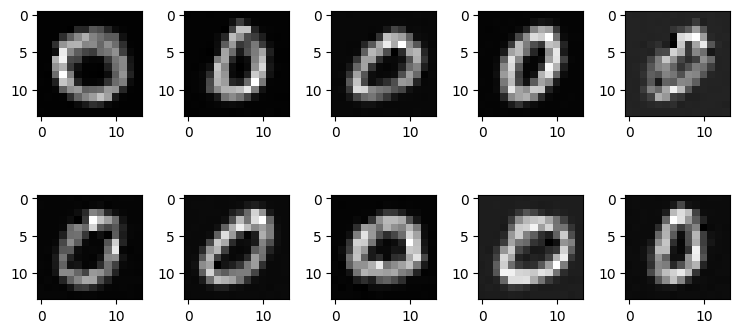

Epoch 401: Train Loss:442.33859577584775 Val BPD: 3.8341493606567383


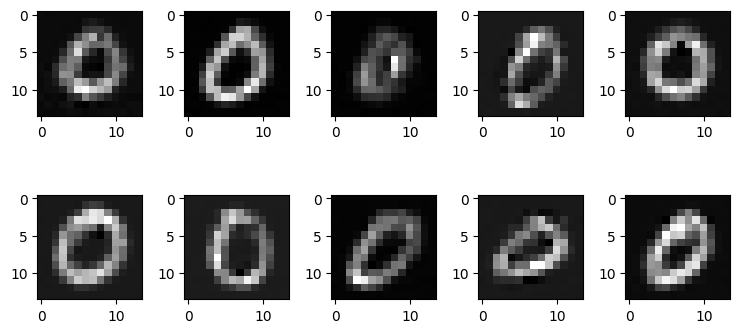

Epoch 411: Train Loss:440.42825057658746 Val BPD: 3.815078020095825


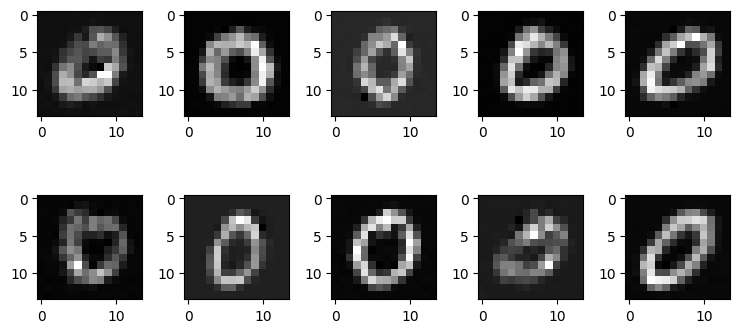

Epoch 421: Train Loss:439.3668264835439 Val BPD: 3.7968575954437256


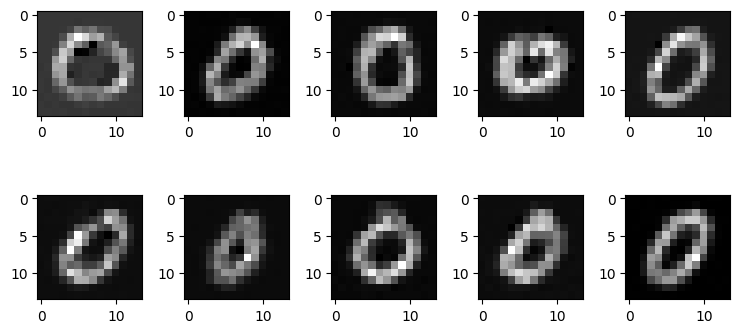

Epoch 431: Train Loss:438.761057752244 Val BPD: 3.7867088317871094


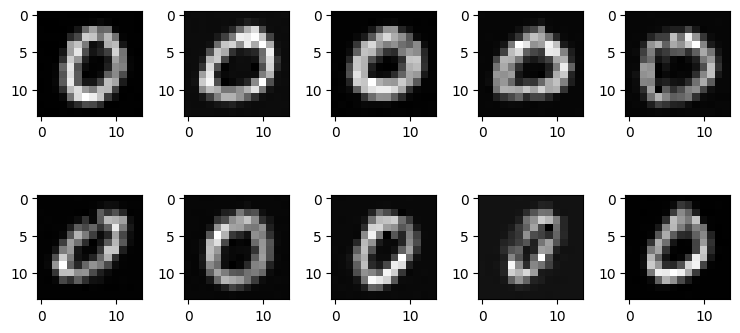

Epoch 441: Train Loss:436.89022242769283 Val BPD: 3.7823073863983154


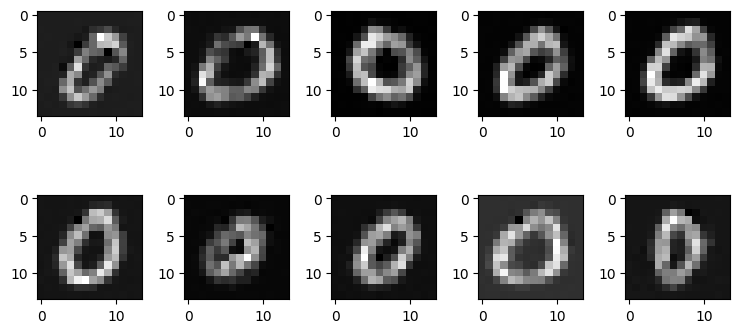

Epoch 451: Train Loss:435.1890193858045 Val BPD: 3.7867183685302734


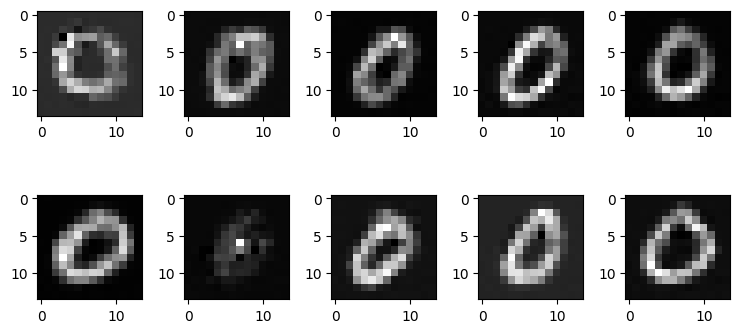

Epoch 461: Train Loss:434.79918589490524 Val BPD: 3.7833099365234375


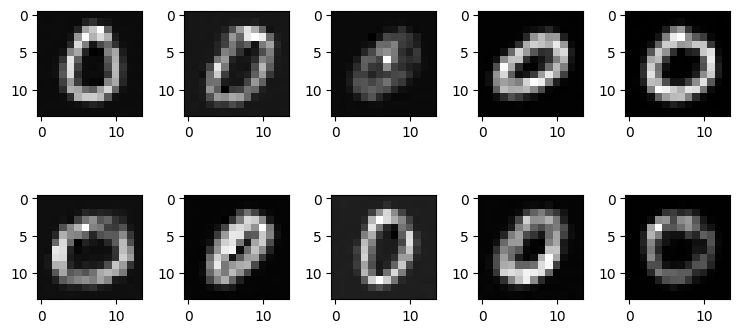

Epoch 471: Train Loss:433.796228936378 Val BPD: 3.744471311569214


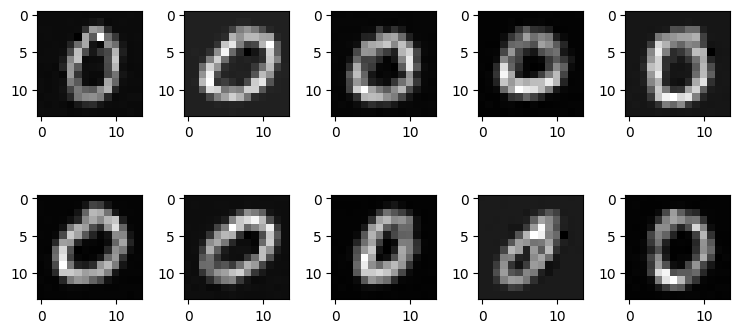

Epoch 481: Train Loss:432.6938983024435 Val BPD: 3.6998374462127686


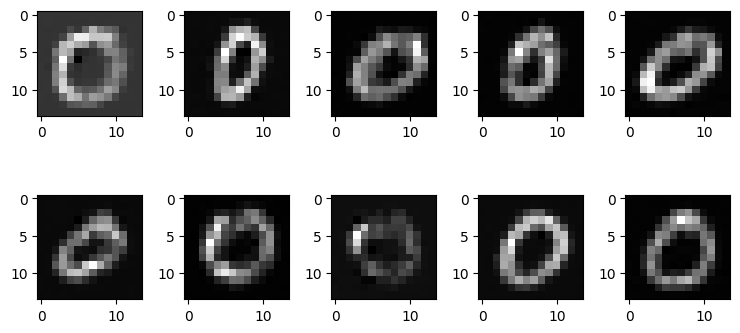

Epoch 491: Train Loss:431.71116345994017 Val BPD: 3.752920627593994


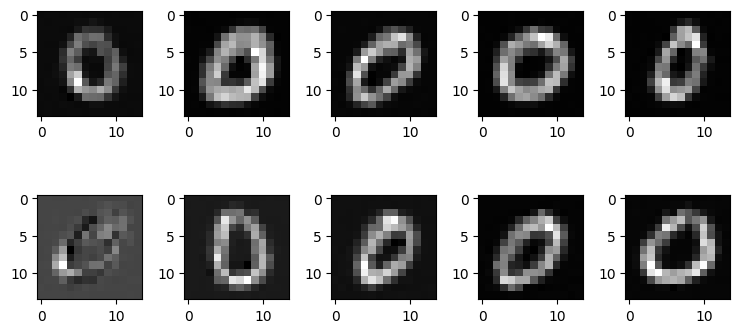

Epoch 501: Train Loss:431.15013479679186 Val BPD: 3.71150279045105


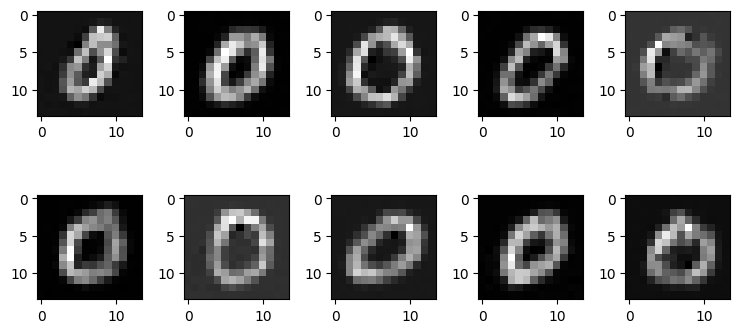

Epoch 511: Train Loss:429.37049183946976 Val BPD: 3.71411395072937


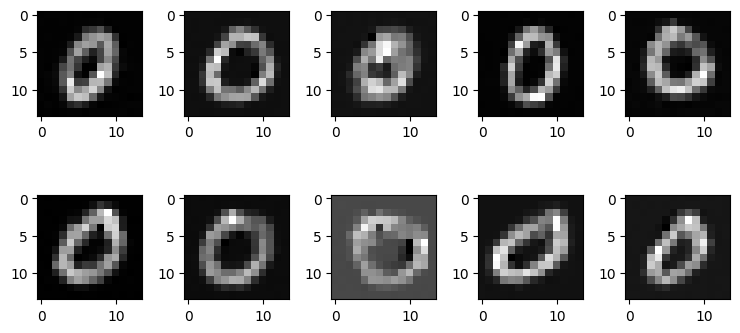

Epoch 521: Train Loss:428.69553391476893 Val BPD: 3.6987011432647705


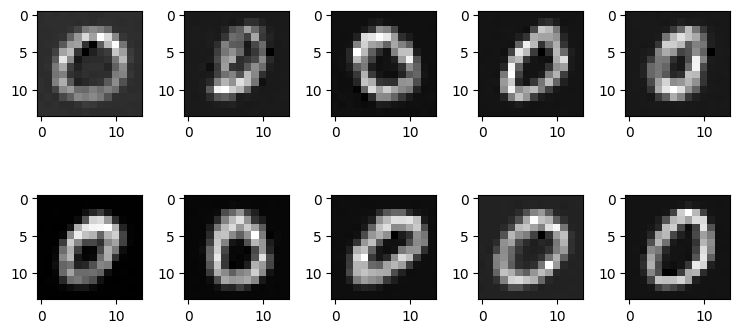

Epoch 531: Train Loss:428.8543331065076 Val BPD: 3.6831865310668945


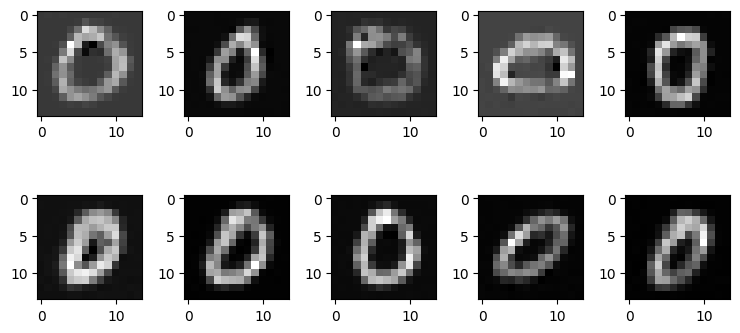

Epoch 541: Train Loss:427.1948073366855 Val BPD: 3.6686766147613525


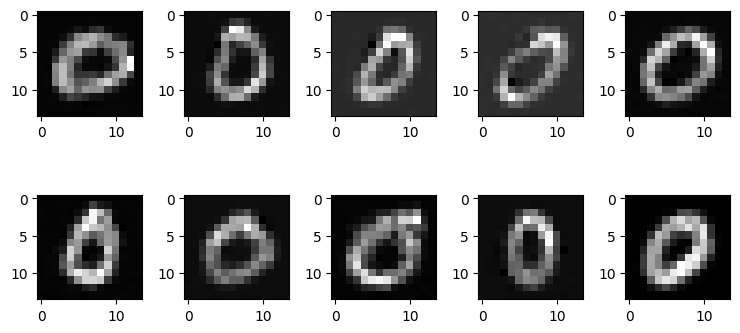

Epoch 551: Train Loss:426.0757868340675 Val BPD: 3.706848621368408


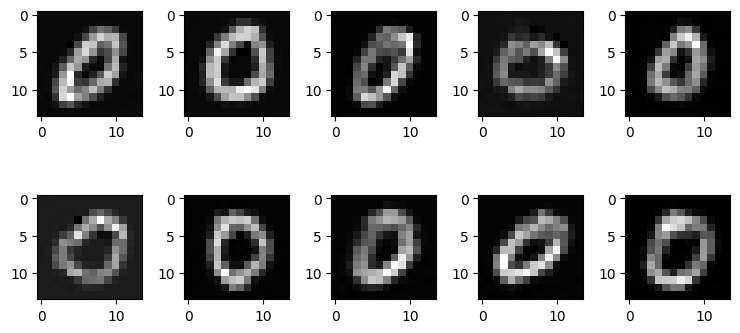

Epoch 561: Train Loss:425.385798677485 Val BPD: 3.7192881107330322


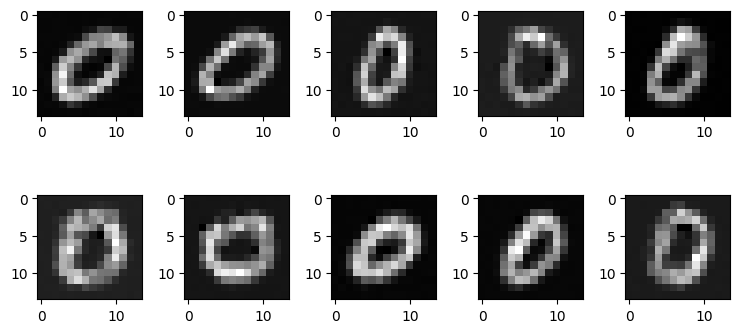

Epoch 571: Train Loss:425.1066401055519 Val BPD: 3.666977643966675


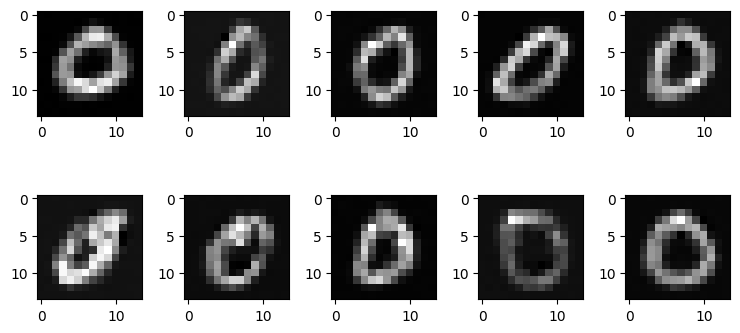

Epoch 581: Train Loss:423.6731599848321 Val BPD: 3.670306921005249


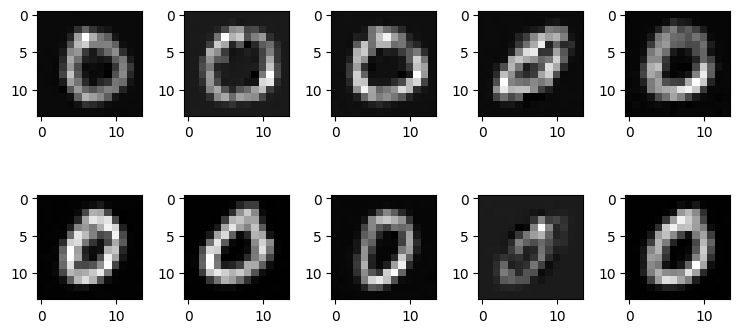

Epoch 591: Train Loss:422.8960934902759 Val BPD: 3.6519925594329834


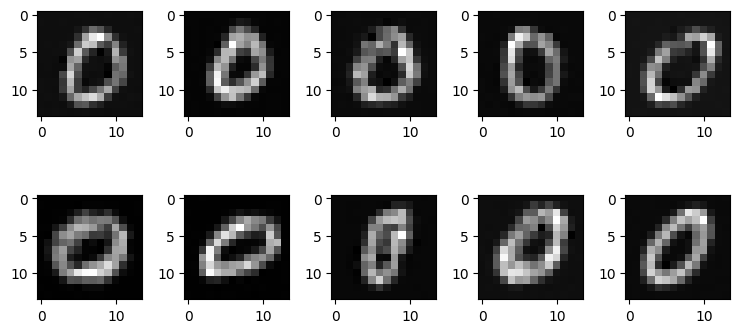

Epoch 601: Train Loss:422.6913036589927 Val BPD: 3.701455593109131


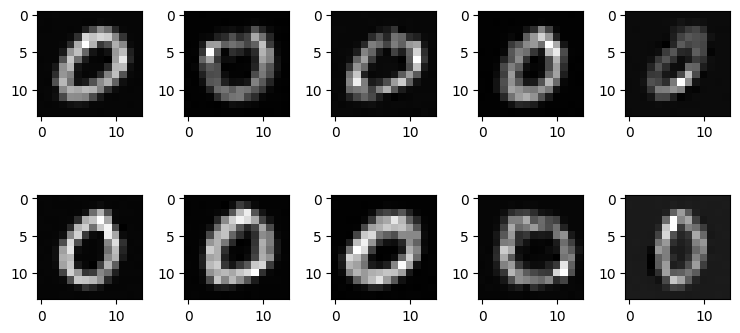

Epoch 611: Train Loss:422.4534535509475 Val BPD: 3.6305835247039795


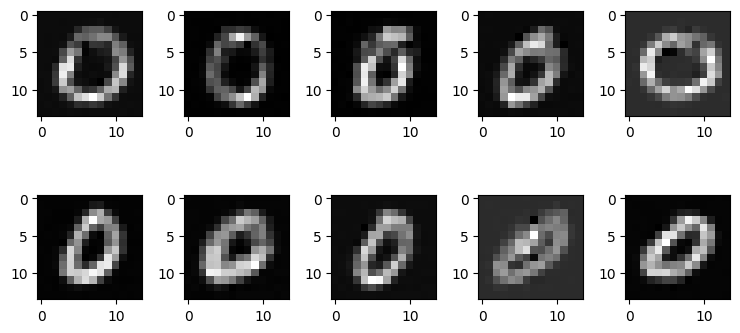

Epoch 621: Train Loss:421.55581859832114 Val BPD: 3.6138834953308105


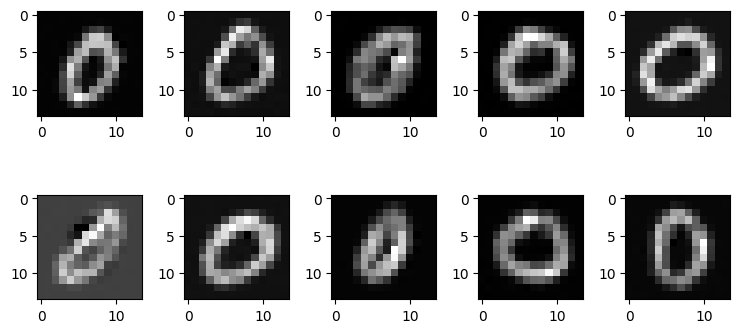

Epoch 631: Train Loss:419.70568912587265 Val BPD: 3.6450304985046387


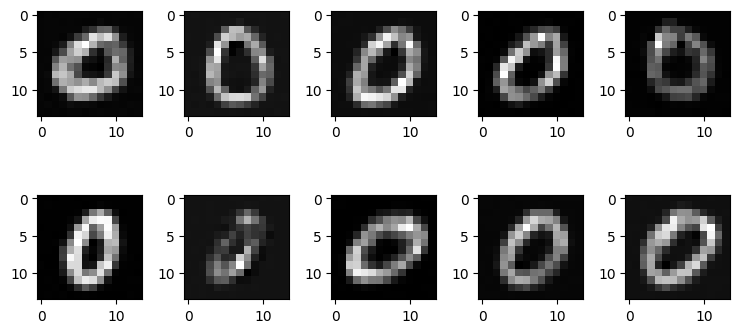

Epoch 641: Train Loss:419.5281417522025 Val BPD: 3.654163122177124


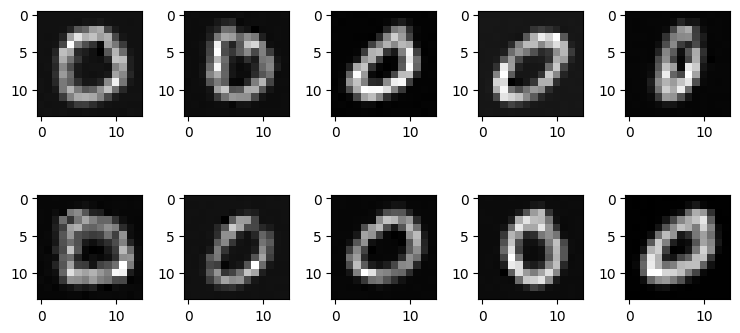

Epoch 651: Train Loss:418.61954189868686 Val BPD: 3.6421360969543457


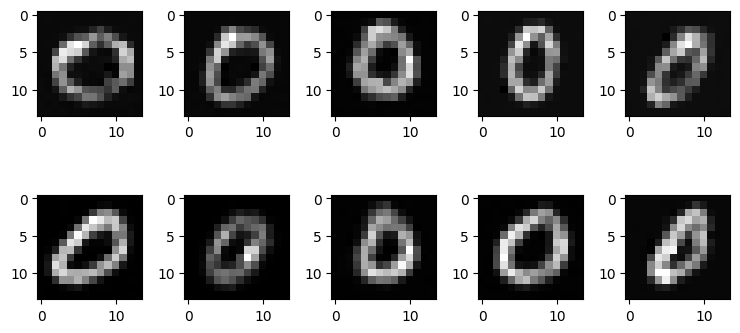

Epoch 661: Train Loss:418.1689946600731 Val BPD: 3.625300168991089


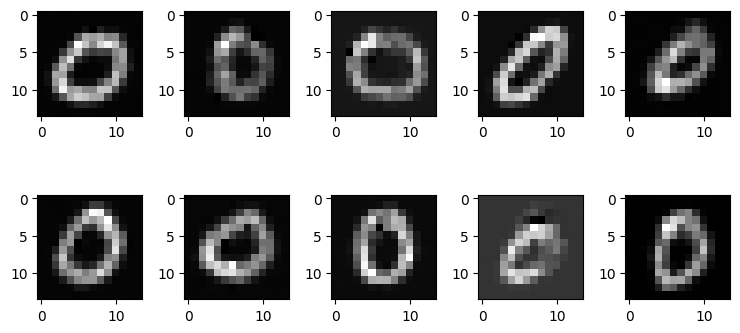

Epoch 671: Train Loss:417.72822798059343 Val BPD: 3.604943037033081


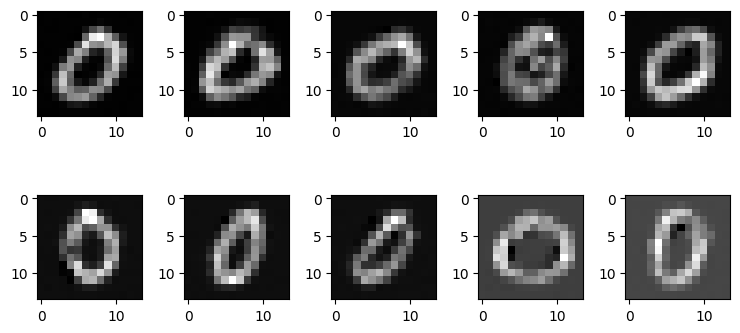

Epoch 681: Train Loss:417.17310349484706 Val BPD: 3.6242306232452393


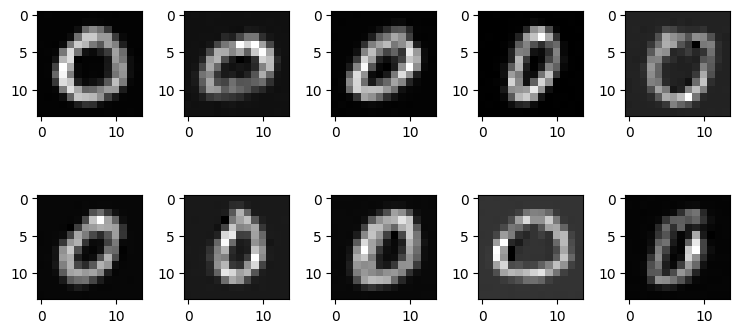

Epoch 691: Train Loss:416.56181627638796 Val BPD: 3.6212642192840576


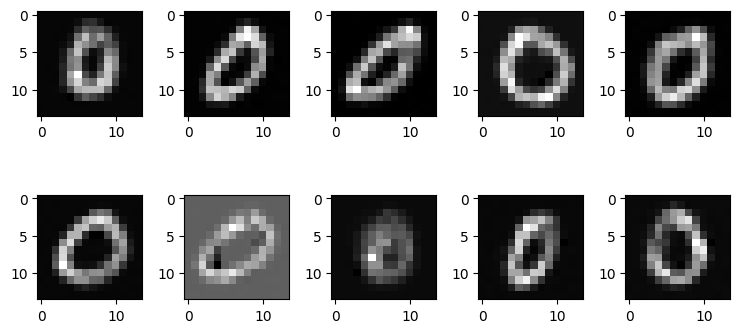

Epoch 701: Train Loss:415.5738350076878 Val BPD: 3.6125168800354004


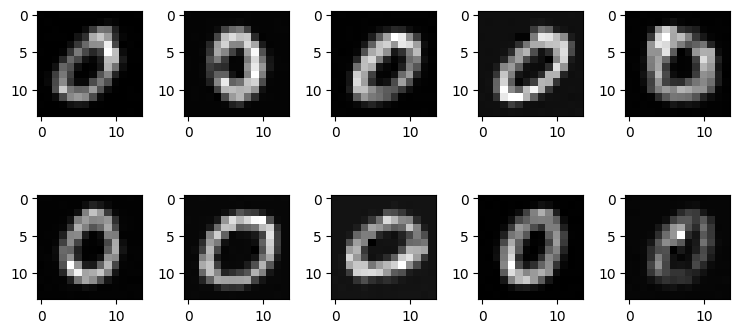

Epoch 711: Train Loss:415.5413656031832 Val BPD: 3.6217405796051025


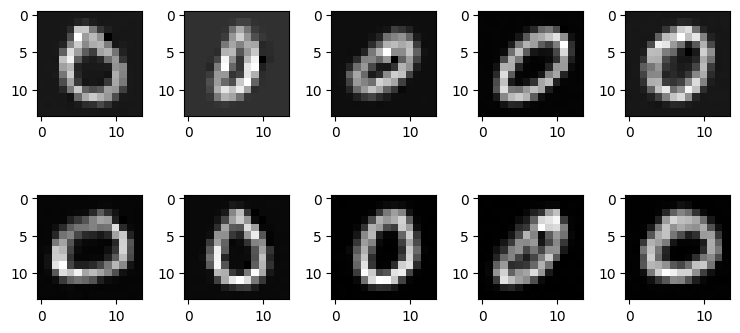

Epoch 721: Train Loss:414.5311318255485 Val BPD: 3.605234146118164


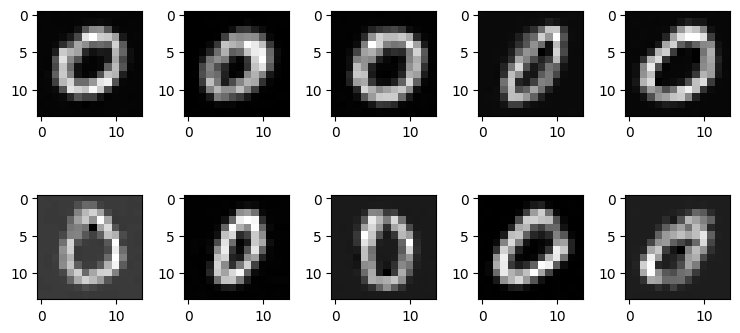

Epoch 731: Train Loss:414.83327727622174 Val BPD: 3.611516237258911


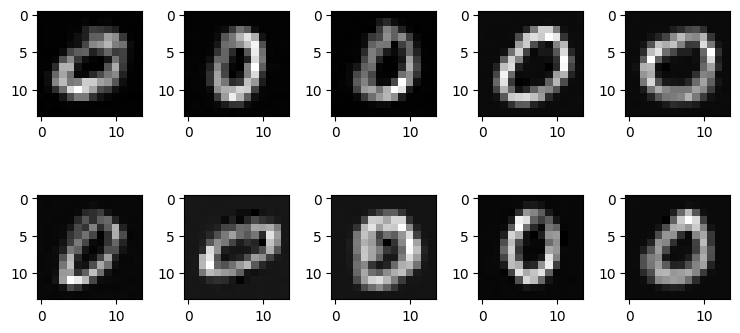

Epoch 741: Train Loss:413.5763874459774 Val BPD: 3.6014010906219482


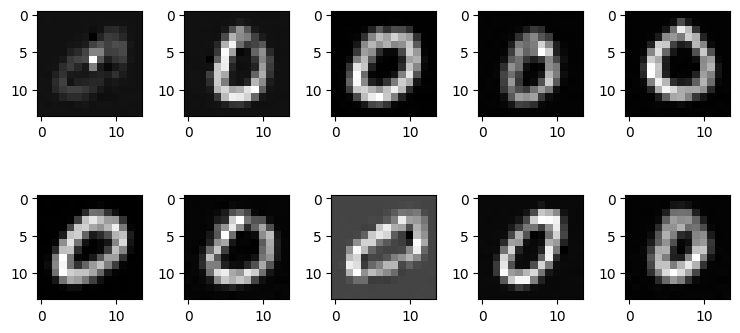

Epoch 751: Train Loss:412.57666859728226 Val BPD: 3.6301333904266357


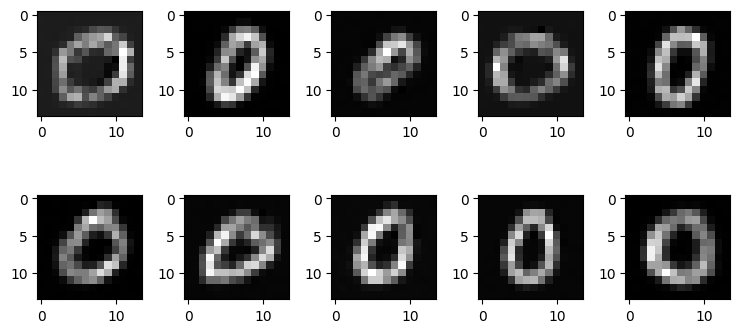

Epoch 761: Train Loss:412.6113774725731 Val BPD: 3.5935230255126953


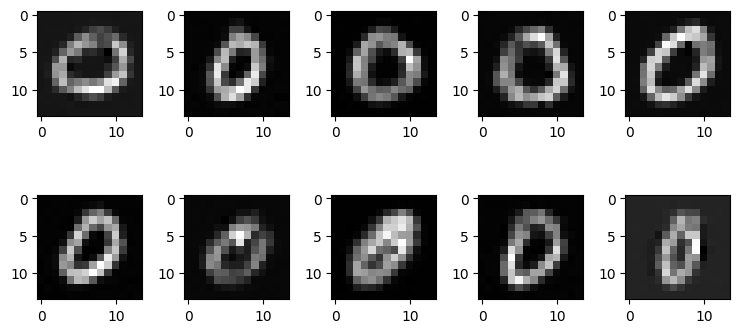

Epoch 771: Train Loss:411.93033291431186 Val BPD: 3.6308751106262207


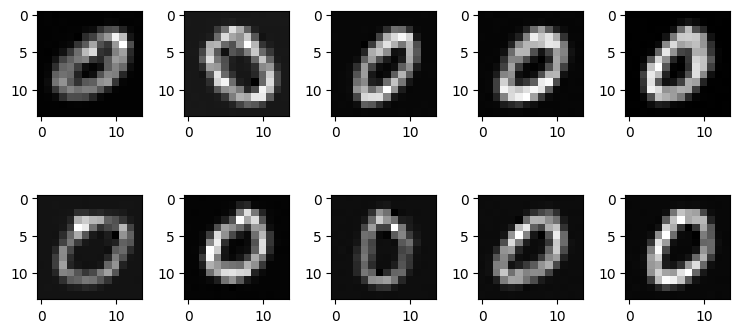

Epoch 781: Train Loss:411.4742762788813 Val BPD: 3.6022841930389404


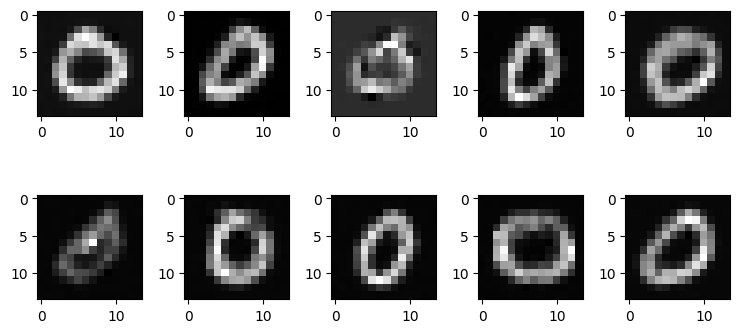

Epoch 791: Train Loss:410.58164945561833 Val BPD: 3.59458065032959


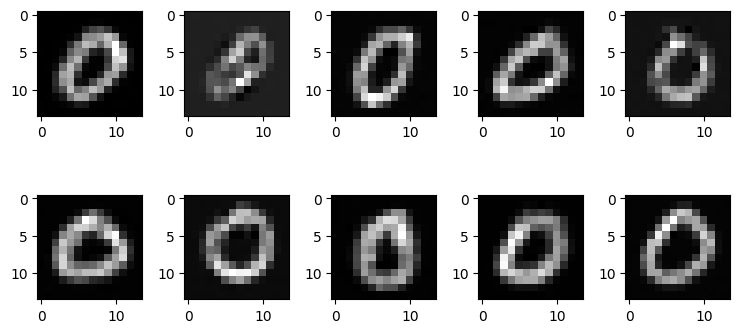

Epoch 801: Train Loss:410.4426782486287 Val BPD: 3.592306137084961


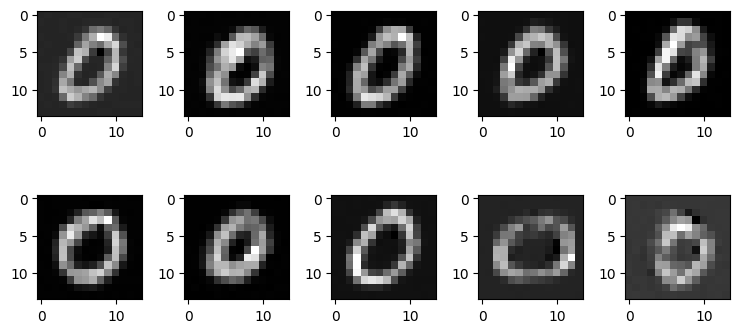

Epoch 811: Train Loss:410.11062297415225 Val BPD: 3.5661282539367676


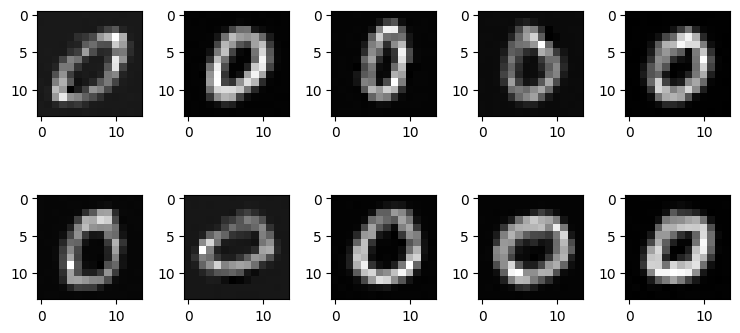

Epoch 821: Train Loss:408.8374679240775 Val BPD: 3.5681328773498535


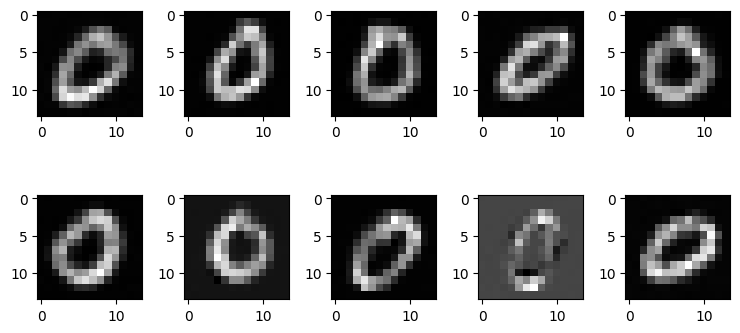

Epoch 831: Train Loss:408.84220788833943 Val BPD: 3.5844810009002686


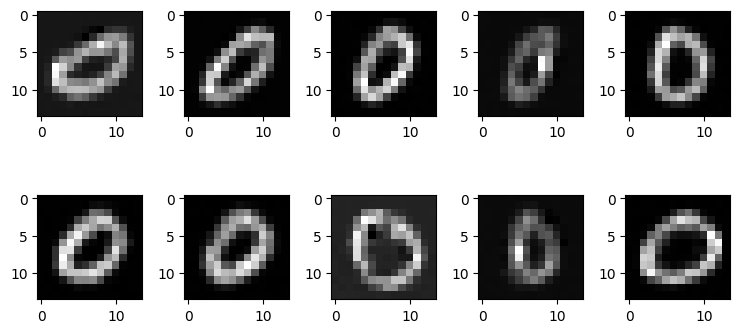

Epoch 841: Train Loss:408.00536460064825 Val BPD: 3.57857084274292


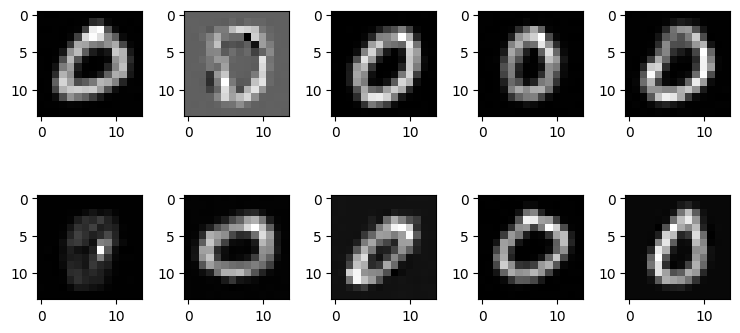

Epoch 851: Train Loss:407.73543857006314 Val BPD: 3.6081383228302


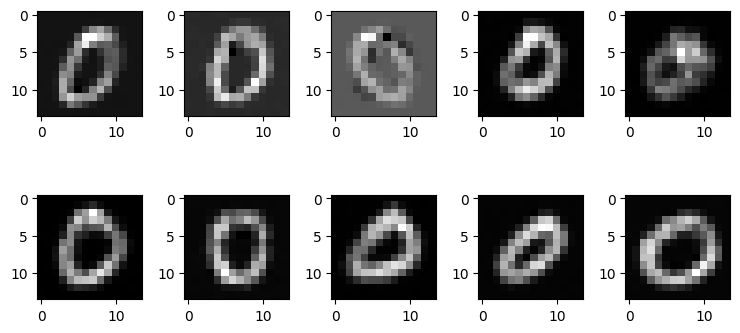

Epoch 861: Train Loss:407.919677734375 Val BPD: 3.6021475791931152


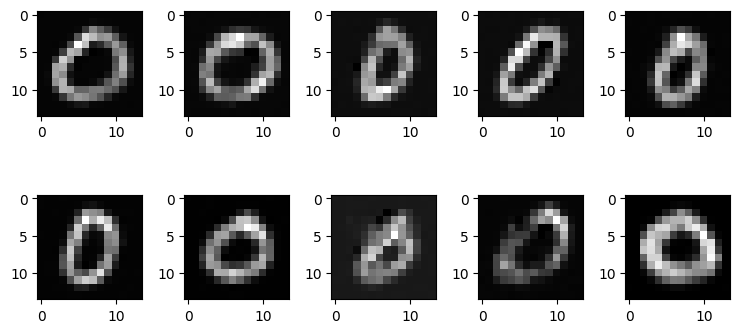

Epoch 871: Train Loss:407.3669271266207 Val BPD: 3.5627598762512207


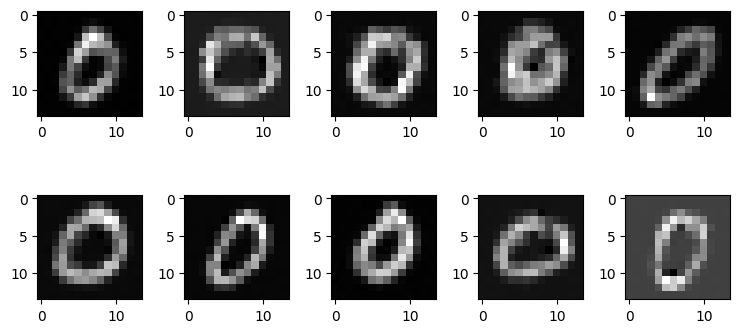

Epoch 881: Train Loss:407.0046860715176 Val BPD: 3.599219560623169


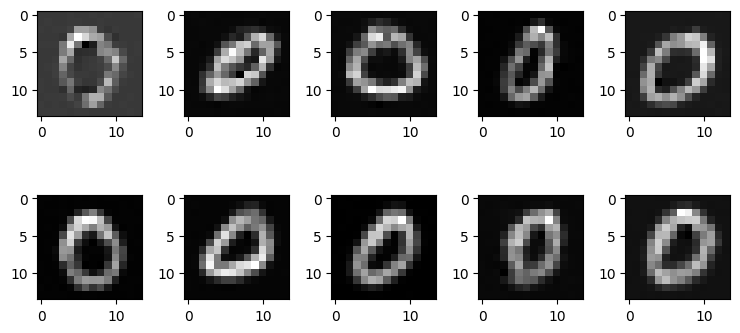

Epoch 891: Train Loss:406.3274458215592 Val BPD: 3.6107497215270996


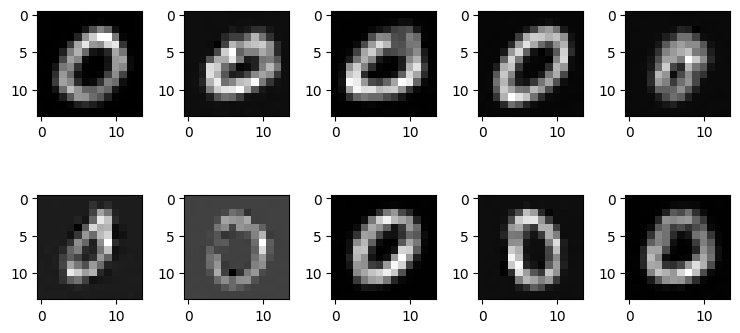

Epoch 901: Train Loss:405.79291485725565 Val BPD: 3.554312229156494


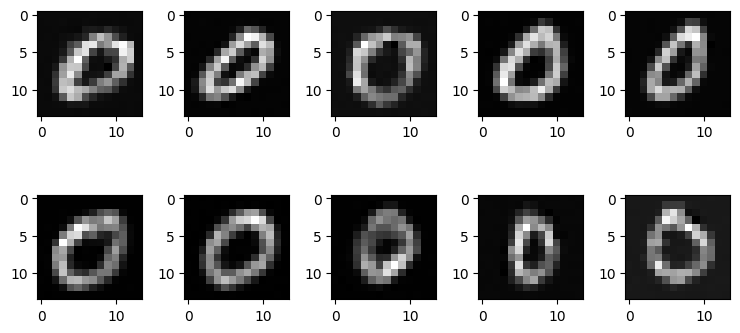

Epoch 911: Train Loss:405.5526213950299 Val BPD: 3.59440279006958


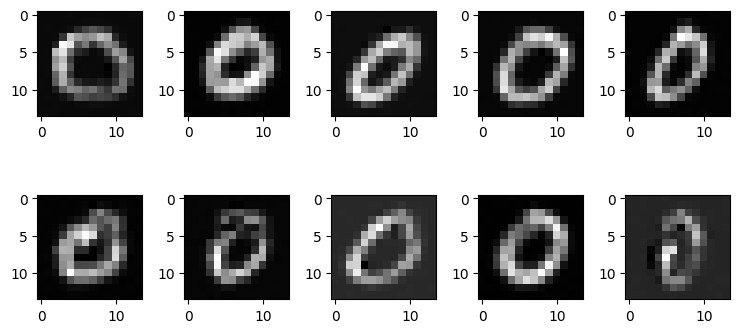

Epoch 921: Train Loss:404.6099892474235 Val BPD: 3.5682127475738525


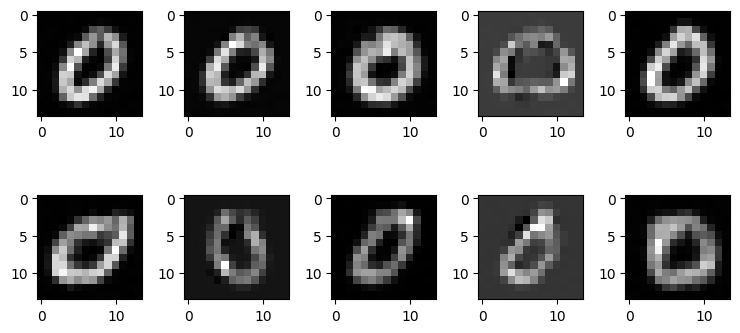

Epoch 931: Train Loss:404.3066601043052 Val BPD: 3.5550336837768555


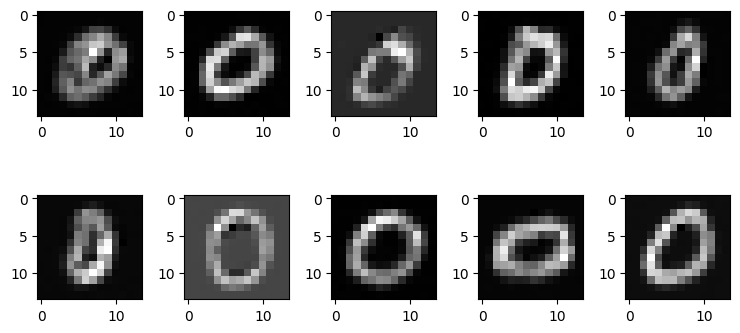

Epoch 941: Train Loss:403.8965869660073 Val BPD: 3.5420470237731934


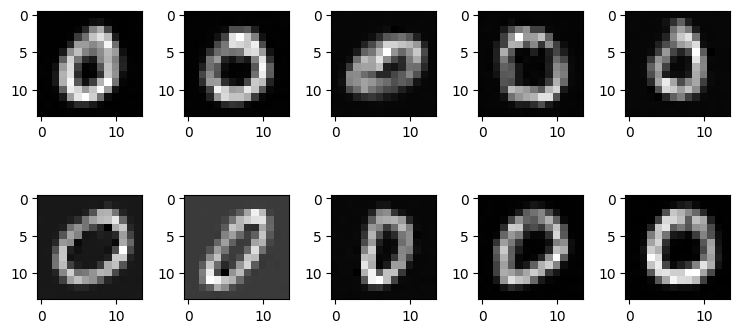

Epoch 951: Train Loss:403.3585607650432 Val BPD: 3.5581798553466797


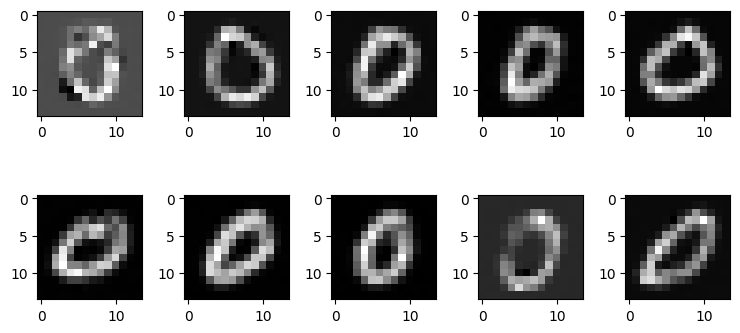

Epoch 961: Train Loss:402.8894211789395 Val BPD: 3.5818724632263184


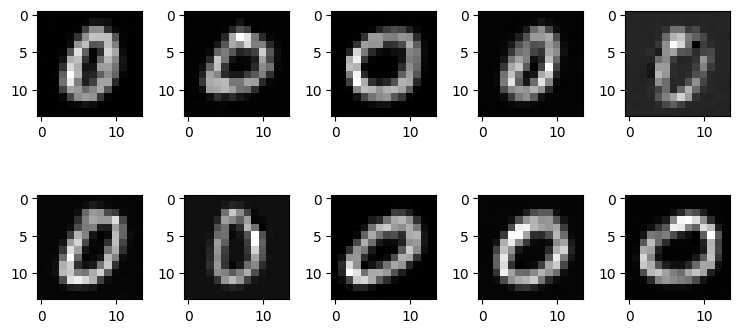

Epoch 971: Train Loss:403.28089937250667 Val BPD: 3.5477359294891357


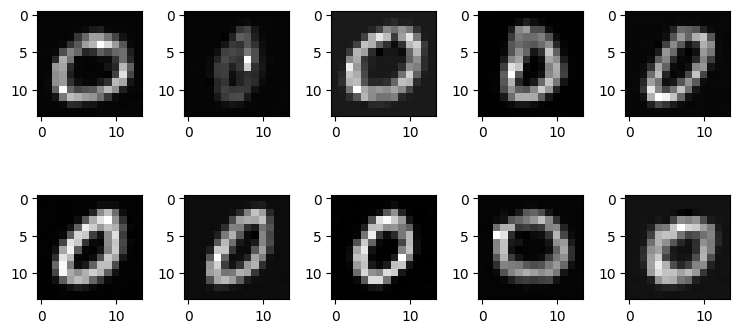

Epoch 981: Train Loss:402.63756155460436 Val BPD: 3.568122148513794


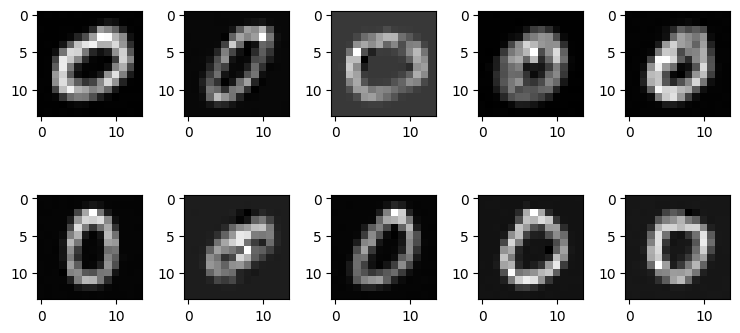

Epoch 991: Train Loss:401.79341028091756 Val BPD: 3.539482831954956


In [47]:
# device = 'mps' if mps.is_available() else 'cpu'
device = 'cpu'
flow = RealNVP(14*14, num_steps=21).to(device)
optim = torch.optim.AdamW(flow.parameters(), lr=1e-5)
epochs = 1000
bits = 8
for ep in range(epochs):
    total_loss = 0.
    iters = 0
    for x, _ in train_loader:
        x = (x * 255).long()
        u = torch.rand_like(x.float())
        x = x + u
        x = x / (2 ** bits)
        x = x.flatten(start_dim=1)

        optim.zero_grad()
        log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (14 * 14)
        loss = - (log_px).mean()
        loss.backward()
        optim.step()
        iters += 1
        total_loss += loss.item()
    if ep % 10 == 0:
        with torch.no_grad():
            val_iters = 0
            total_bpd = 0.
            for x, _ in test_loader:
                x = (x * 255).long()
                u = torch.rand_like(x.float())
                x = x + u
                x = x / (2 ** bits)
                x = x.flatten(start_dim=1)
                log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (14 * 14)
                bpd = -(log_px).mean().cpu() / (np.log(2) * (14 * 14))
                total_bpd += bpd
                val_iters += 1
        samples = flow.sample(10).detach().cpu()
        samples = torch.unflatten(samples, dim=1, sizes=(14, 14)).unsqueeze(1)

        plot_mnist(samples[:, 0], 2, 5)

        print(f"Epoch {ep+1}: Train Loss:{total_loss / iters} Val BPD: {total_bpd / val_iters}")

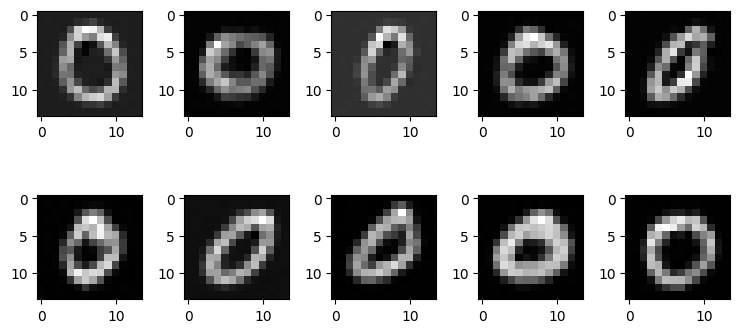

In [48]:
samples = flow.sample(10).detach().cpu()
samples = torch.unflatten(samples, dim=1, sizes=(14, 14)).unsqueeze(1)
plot_mnist(samples[:,0], 2, 5)

## Bonus zadatak

Predložite implementaciju konvolucijskog normalizirajućeg toka.